In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import simulators.cosmic_shear.cosmic_shear as cosmic_shear
import ndes.nde as nde
import distributions.priors as priors
%matplotlib inline

Using Theano backend.


In [2]:
### SET UP FOR SIMULATION CODE ###

# n(z)
#pz_fid = pickle.load(open('pz_euclid.pkl', 'rb'))
nz = 10
pz = np.loadtxt('simulators/cosmic_shear/pz.dat')
z = pz[0,:]
pz_fid = [0]*nz
for i in range(1, nz+1):
    pz_fid[i-1] = interpolate.InterpolatedUnivariateSpline(z, pz[i,:])

# Set up fiducial parameters and binning
theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
nz = 10
npar = 5
n_data = 5

# Define the priors
lower = np.array([0, 0.4, 0, 0.4, 0.7])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3])
prior_mean = theta_fiducial
sigmas = np.zeros(npar)
sigmas[0:5] = np.array([0.1, 0.1, 0.05, 0.3, 0.3])
Q = np.eye(npar)*sigmas**2
Qinv = np.linalg.inv(Q)
prior_args = [prior_mean, Q, lower, upper]

# Parameter names and ranges for plotting  
names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s']
labels =  ['\\Omega_m', 'S_8', '\\Omega_b', 'h', 'n_s']
ranges = {'\Omega_m':[lower[0], upper[0]], 'S_8':[lower[1],upper[1]],'\Omega_b':[lower[2],upper[2]],
            'h':[lower[3],upper[3]],'n_s':[lower[4],upper[4]]}

# Scale binning
lmax = 3000
lmin = 10
modes_edges = np.logspace(np.log10(lmin), np.log10(lmax), 11)
modes = (modes_edges[0:-1] + modes_edges[1:])/2
l = np.arange(lmin, lmax)
nl = np.array([sum((2*l[(l >= modes_edges[i])*(l < modes_edges[i+1])] + 1)) for i in range(len(modes))], dtype=int)

# Number of effective modes
A_sky = 15000*(np.pi/180)**2
f_sky = A_sky/(4*np.pi)
nl = np.array(nl*f_sky, dtype=int)

# Noise covariance
sigma_e = 0.3
nbar = 3*(60*180./np.pi)**2
N = (sigma_e**2/nbar)*np.eye(nz)

# Fiducial power spectrum
C = cosmic_shear.power_spectrum(theta_fiducial, pz_fid, modes, N)
Cinv = np.array([np.linalg.inv(C[:,:,l]) for l in range(len(modes))]).T

# Derivative of power spectrum
h = np.array(abs(theta_fiducial[0:5])*np.array([0.05, 0.05, 0.05, 0.05, 0.05]))
dCdt = np.zeros((npar, nz, nz, len(modes)))

# Derivatives wrt cosmological parameters
for i in range(npar):
    theta_plus = np.copy(theta_fiducial)
    theta_plus[i] += h[i]
    theta_minus = np.copy(theta_fiducial)
    theta_minus[i] -= h[i]
    
    Cp = cosmic_shear.power_spectrum(theta_plus, pz_fid, modes, np.zeros((nz, nz)))
    Cm = cosmic_shear.power_spectrum(theta_minus, pz_fid, modes, np.zeros((nz, nz)))

    dCdt[i, :, :, :] = (Cp - Cm)/(2*h[i])

# Fisher matrix
F, Finv, fisher_errors = cosmic_shear.fisher_matrix(Cinv, dCdt, npar, nl, Qinv)

In [3]:
# Define the simulator function: takes parameters, spits out simulated data
# Should have the form: simulator(parameters, args) -> simulated dataset
simulator = cosmic_shear.simulate
simulator_args = [pz_fid, modes, N, nl]

In [4]:
# Define the compression function: takes data, spits out compressed summaries
# Should have the form compressor(data, args) -> compressed summaries
# NB: compression should be set-up like a quasi maximum-likelihood estimator
compressor = cosmic_shear.score
compressor_args = [Finv, theta_fiducial, prior_mean, Qinv, Cinv, dCdt, nl, modes]

In [5]:
# The data vector: import or otherwise simulate for testing
#data = compressor(cosmic_shear.power_spectrum(theta_fiducial, pz_fid, modes, N), compressor_args)
data = compressor(simulator(theta_fiducial, simulator_args), compressor_args)

In [6]:
# Create prior over parameters
prior = priors.TruncatedGaussian(prior_mean, Q, lower, upper)

In [7]:
# Create the DELFI MDN object
n_components = 3

mdn = nde.DelfiMixtureDensityNetwork(data, prior, [lower, upper], Finv, theta_fiducial, n_components, n_hidden = [50, 50], activations = ['tanh', 'tanh'], names = names, labels = labels, ranges = ranges)

Generating pre-training data...
Training on the pre-training data...
Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 77s 2ms/step - loss: 46.5625 - val_loss: 20.2855
Epoch 2/100
45000/45000 [==============================] - 76s 2ms/step - loss: 17.8307 - val_loss: 16.7091
Epoch 3/100
45000/45000 [==============================] - 80s 2ms/step - loss: 16.4571 - val_loss: 16.6173
Epoch 4/100
45000/45000 [==============================] - 71s 2ms/step - loss: 15.5978 - val_loss: 15.3673
Epoch 5/100
45000/45000 [==============================] - 89s 2ms/step - loss: 15.3620 - val_loss: 15.5131
Epoch 6/100
45000/45000 [==============================] - 97s 2ms/step - loss: 14.9650 - val_loss: 14.8418
Epoch 7/100
45000/45000 [==============================] - 118s 3ms/step - loss: 14.6801 - val_loss: 15.0719
Epoch 8/100
45000/45000 [==============================] - 110s 2ms/step - loss: 14.2804 - val_loss: 13.7751
Epoch 9/100
4500

45000/45000 [==============================] - 98s 2ms/step - loss: 6.3475 - val_loss: 6.3589
Epoch 77/100
45000/45000 [==============================] - 97s 2ms/step - loss: 6.3339 - val_loss: 6.2311
Epoch 78/100
45000/45000 [==============================] - 96s 2ms/step - loss: 6.2507 - val_loss: 6.3812
Epoch 79/100
45000/45000 [==============================] - 96s 2ms/step - loss: 6.2429 - val_loss: 6.2577
Epoch 80/100
45000/45000 [==============================] - 100s 2ms/step - loss: 6.2424 - val_loss: 6.3870
Epoch 81/100
45000/45000 [==============================] - 96s 2ms/step - loss: 6.2073 - val_loss: 6.3104
Epoch 82/100
45000/45000 [==============================] - 98s 2ms/step - loss: 6.2003 - val_loss: 6.6775
Epoch 83/100
45000/45000 [==============================] - 96s 2ms/step - loss: 6.1661 - val_loss: 6.2957
Epoch 84/100
45000/45000 [==============================] - 97s 2ms/step - loss: 6.1203 - val_loss: 6.1481
Epoch 85/100
45000/45000 [=======================

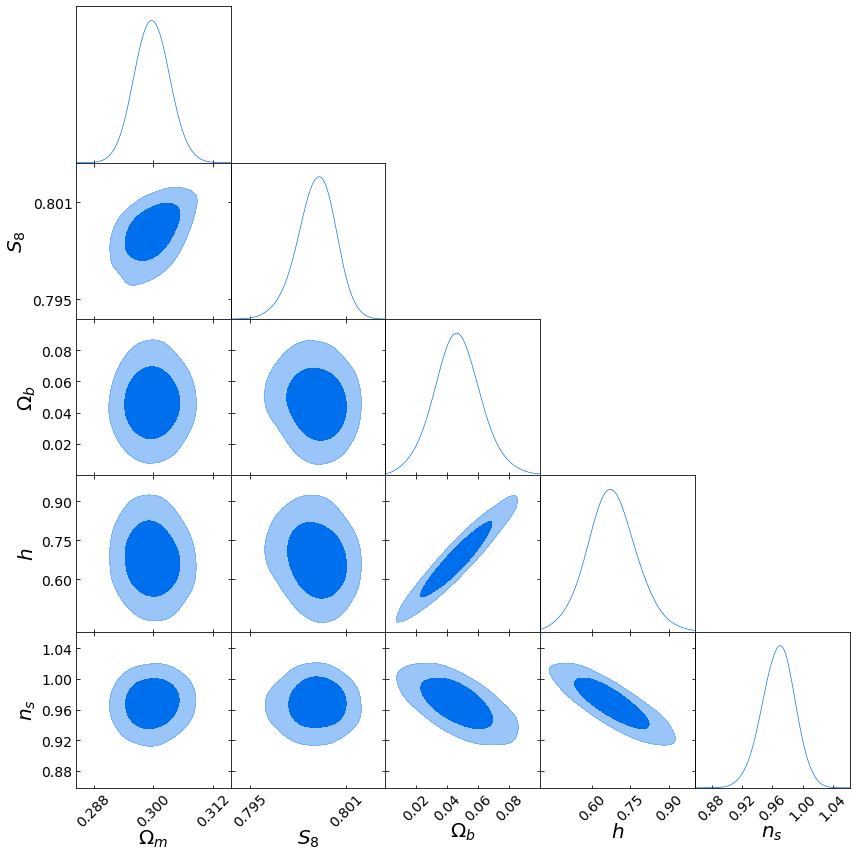

In [8]:
# Do the Fisher pre-training
mdn.fisher_pretraining(50000, prior, epochs=100)

Running initial 500 sims...
Done.
Train on 450 samples, validate on 50 samples
Epoch 1/100
450/450 [==============================] - 1s 1ms/step - loss: 13.1811 - val_loss: 11.4353
Epoch 2/100
450/450 [==============================] - 1s 1ms/step - loss: 9.4144 - val_loss: 8.7849
Epoch 3/100
450/450 [==============================] - 1s 1ms/step - loss: 8.5000 - val_loss: 8.1676
Epoch 4/100
450/450 [==============================] - 1s 1ms/step - loss: 7.9229 - val_loss: 8.0530
Epoch 5/100
450/450 [==============================] - 1s 1ms/step - loss: 7.5966 - val_loss: 7.6720
Epoch 6/100
450/450 [==============================] - 1s 1ms/step - loss: 7.0357 - val_loss: 7.0681
Epoch 7/100
450/450 [==============================] - 1s 1ms/step - loss: 6.7899 - val_loss: 6.9372
Epoch 8/100
450/450 [==============================] - 1s 1ms/step - loss: 6.5140 - val_loss: 7.1052
Epoch 9/100
450/450 [==============================] - 1s 1ms/step - loss: 6.2975 - val_loss: 6.9922
Epoch 10/1

450/450 [==============================] - 1s 1ms/step - loss: 4.6247 - val_loss: 4.9462
Epoch 81/100
450/450 [==============================] - 1s 1ms/step - loss: 4.5783 - val_loss: 4.8817
Epoch 82/100
450/450 [==============================] - 1s 1ms/step - loss: 4.5832 - val_loss: 4.9381
Epoch 83/100
450/450 [==============================] - 1s 1ms/step - loss: 4.5906 - val_loss: 5.0050
Epoch 84/100
450/450 [==============================] - 1s 1ms/step - loss: 4.5642 - val_loss: 4.9788
Epoch 85/100
450/450 [==============================] - 1s 1ms/step - loss: 4.5282 - val_loss: 4.8708
Epoch 86/100
450/450 [==============================] - 1s 1ms/step - loss: 4.5320 - val_loss: 4.9461
Epoch 87/100
450/450 [==============================] - 1s 1ms/step - loss: 4.5501 - val_loss: 5.0647
Epoch 88/100
450/450 [==============================] - 1s 1ms/step - loss: 4.5714 - val_loss: 4.8479
Epoch 89/100
450/450 [==============================] - 1s 1ms/step - loss: 4.5502 - val_loss: 

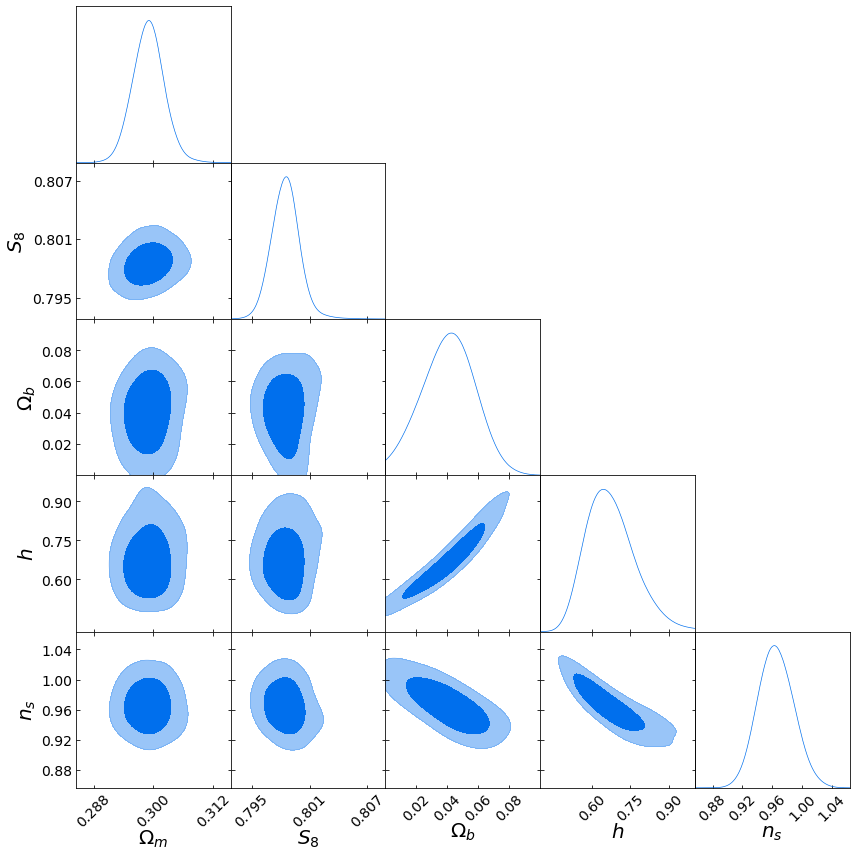

Population 1/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 1s 1ms/step - loss: 4.4354 - val_loss: 4.3267
Epoch 2/100
900/900 [==============================] - 1s 1ms/step - loss: 4.5228 - val_loss: 4.4202
Epoch 3/100
900/900 [==============================] - 1s 1ms/step - loss: 4.5308 - val_loss: 4.2233
Epoch 4/100
900/900 [==============================] - 1s 1ms/step - loss: 4.4838 - val_loss: 4.3905
Epoch 5/100
900/900 [==============================] - 1s 1ms/step - loss: 4.4626 - val_loss: 4.0649
Epoch 6/100
900/900 [==============================] - 1s 1ms/step - loss: 4.3603 - val_loss: 4.0834
Epoch 7/100
900/900 [==============================] - 1s 1ms/step - loss: 4.3111 - val_loss: 4.2204
Epoch 8/100
900/900 [==============================] - 1s 1ms/step - loss: 4.3667 - val_loss: 4.1629
Epoch 9/100
900/900 [==============================] - 1s 1ms/step - 

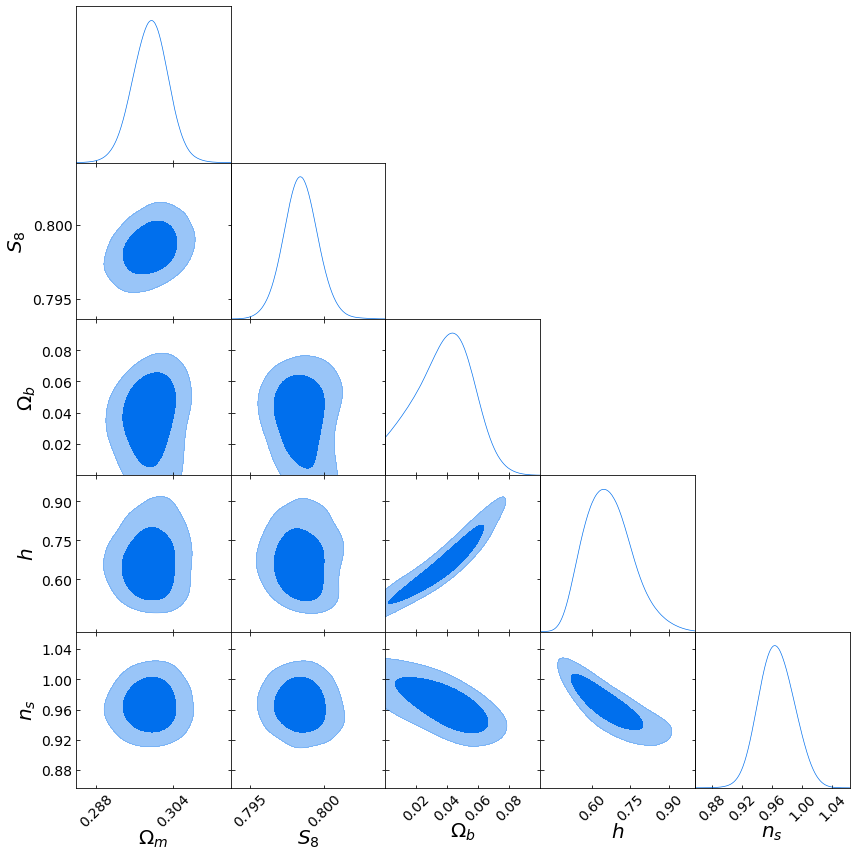

Population 2/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 1350 samples, validate on 150 samples
Epoch 1/100
1350/1350 [==============================] - 2s 1ms/step - loss: 4.1486 - val_loss: 4.0288
Epoch 2/100
1350/1350 [==============================] - 2s 1ms/step - loss: 4.1477 - val_loss: 4.1012
Epoch 3/100
1350/1350 [==============================] - 2s 1ms/step - loss: 4.1663 - val_loss: 3.9457
Epoch 4/100
1350/1350 [==============================] - 2s 1ms/step - loss: 4.2164 - val_loss: 4.0373
Epoch 5/100
1350/1350 [==============================] - 2s 1ms/step - loss: 4.1830 - val_loss: 3.9119
Epoch 6/100
1350/1350 [==============================] - 2s 1ms/step - loss: 4.1538 - val_loss: 3.9462
Epoch 7/100
1350/1350 [==============================] - 2s 1ms/step - loss: 4.0993 - val_loss: 3.9102
Epoch 8/100
1350/1350 [==============================] - 2s 1ms/step - loss: 4.1117 - val_loss: 3.8561
Epoch 9/100
1350/1350 [=============================

1350/1350 [==============================] - 2s 1ms/step - loss: 3.9444 - val_loss: 3.9432
Epoch 79/100
1350/1350 [==============================] - 2s 1ms/step - loss: 3.9991 - val_loss: 3.7199
Epoch 80/100
1350/1350 [==============================] - 2s 1ms/step - loss: 3.8557 - val_loss: 3.8977
Epoch 81/100
1350/1350 [==============================] - 2s 1ms/step - loss: 3.8810 - val_loss: 3.6521
Epoch 82/100
1350/1350 [==============================] - 2s 1ms/step - loss: 3.8501 - val_loss: 3.7609
Epoch 83/100
1350/1350 [==============================] - 2s 1ms/step - loss: 3.7940 - val_loss: 3.5786
Epoch 84/100
1350/1350 [==============================] - 2s 1ms/step - loss: 3.8618 - val_loss: 3.6450
Epoch 85/100
1350/1350 [==============================] - 2s 1ms/step - loss: 3.9006 - val_loss: 3.7707
Epoch 86/100
1350/1350 [==============================] - 2s 1ms/step - loss: 3.9661 - val_loss: 3.6220
Epoch 87/100
1350/1350 [==============================] - 2s 1ms/step - loss:

Epoch 57/100
1350/1350 [==============================] - 2s 2ms/step - loss: 3.6756 - val_loss: 3.4948
Epoch 58/100
1350/1350 [==============================] - 2s 2ms/step - loss: 3.6752 - val_loss: 3.4939
Epoch 59/100
1350/1350 [==============================] - 2s 2ms/step - loss: 3.6751 - val_loss: 3.4938
Epoch 60/100
1350/1350 [==============================] - 2s 2ms/step - loss: 3.6747 - val_loss: 3.4926
Epoch 61/100
1350/1350 [==============================] - 2s 2ms/step - loss: 3.6744 - val_loss: 3.4914
Epoch 62/100
1350/1350 [==============================] - 2s 2ms/step - loss: 3.6743 - val_loss: 3.4916
Epoch 63/100
1350/1350 [==============================] - 2s 2ms/step - loss: 3.6739 - val_loss: 3.4927
Epoch 64/100
1350/1350 [==============================] - 2s 2ms/step - loss: 3.6739 - val_loss: 3.4920
Epoch 65/100
1350/1350 [==============================] - 2s 2ms/step - loss: 3.6736 - val_loss: 3.4914
Epoch 66/100
1350/1350 [==============================] - 2s 2ms

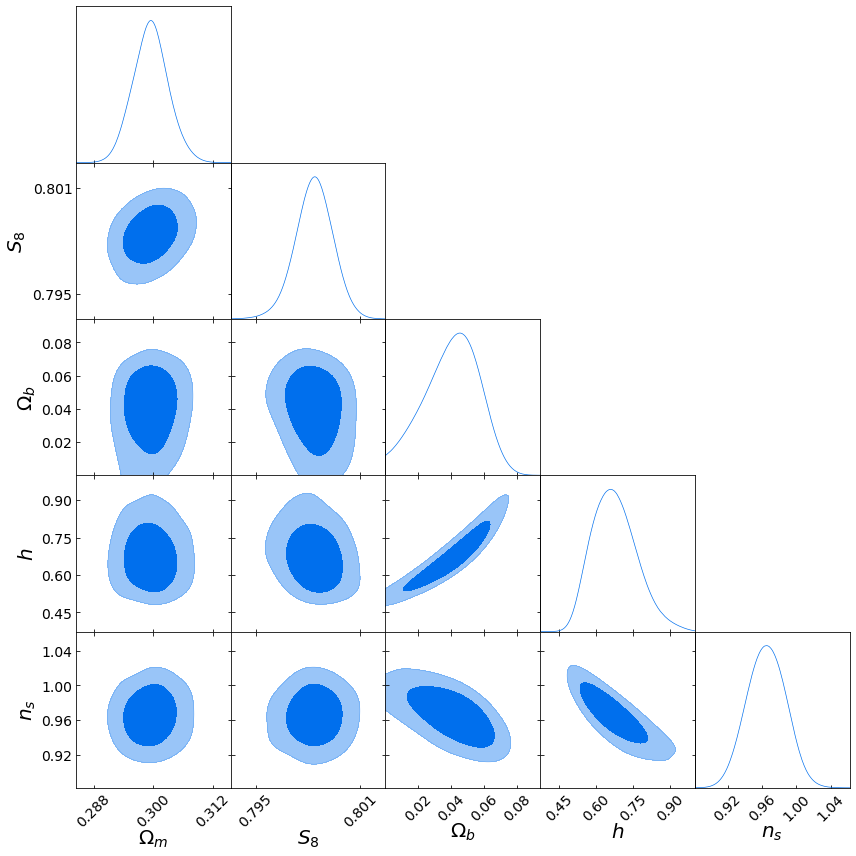

Population 3/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 1800 samples, validate on 200 samples
Epoch 1/100
1800/1800 [==============================] - 3s 1ms/step - loss: 3.6954 - val_loss: 4.0776
Epoch 2/100
1800/1800 [==============================] - 3s 1ms/step - loss: 3.7775 - val_loss: 4.2170
Epoch 3/100
1800/1800 [==============================] - 3s 1ms/step - loss: 3.7248 - val_loss: 4.2079
Epoch 4/100
1800/1800 [==============================] - 3s 1ms/step - loss: 3.9350 - val_loss: 4.1292
Epoch 5/100
1800/1800 [==============================] - 3s 1ms/step - loss: 3.8421 - val_loss: 4.0215
Epoch 6/100
1800/1800 [==============================] - 3s 1ms/step - loss: 3.7522 - val_loss: 4.0137
Epoch 7/100
1800/1800 [==============================] - 3s 1ms/step - loss: 3.7811 - val_loss: 4.0718
Epoch 8/100
1800/1800 [==============================] - 3s 1ms/step - loss: 3.7278 - val_loss: 3.9391
Epoch 9/100
1800/1800 [=============================

Epoch 21/100
1800/1800 [==============================] - 3s 2ms/step - loss: 3.5439 - val_loss: 3.9108
Epoch 22/100
1800/1800 [==============================] - 3s 2ms/step - loss: 3.5260 - val_loss: 3.8858
Epoch 23/100
1800/1800 [==============================] - 3s 2ms/step - loss: 3.5387 - val_loss: 3.8931
Epoch 24/100
1800/1800 [==============================] - 3s 2ms/step - loss: 3.5233 - val_loss: 3.9072
Epoch 25/100
1800/1800 [==============================] - 3s 2ms/step - loss: 3.5318 - val_loss: 3.8486
Epoch 26/100
1800/1800 [==============================] - 3s 2ms/step - loss: 3.5215 - val_loss: 3.8323
Epoch 27/100
1800/1800 [==============================] - 3s 2ms/step - loss: 3.5297 - val_loss: 3.8421
Epoch 28/100
1800/1800 [==============================] - 3s 2ms/step - loss: 3.5219 - val_loss: 3.8531
Epoch 29/100
1800/1800 [==============================] - 3s 2ms/step - loss: 3.5258 - val_loss: 3.8392
Epoch 30/100
1800/1800 [==============================] - 3s 2ms

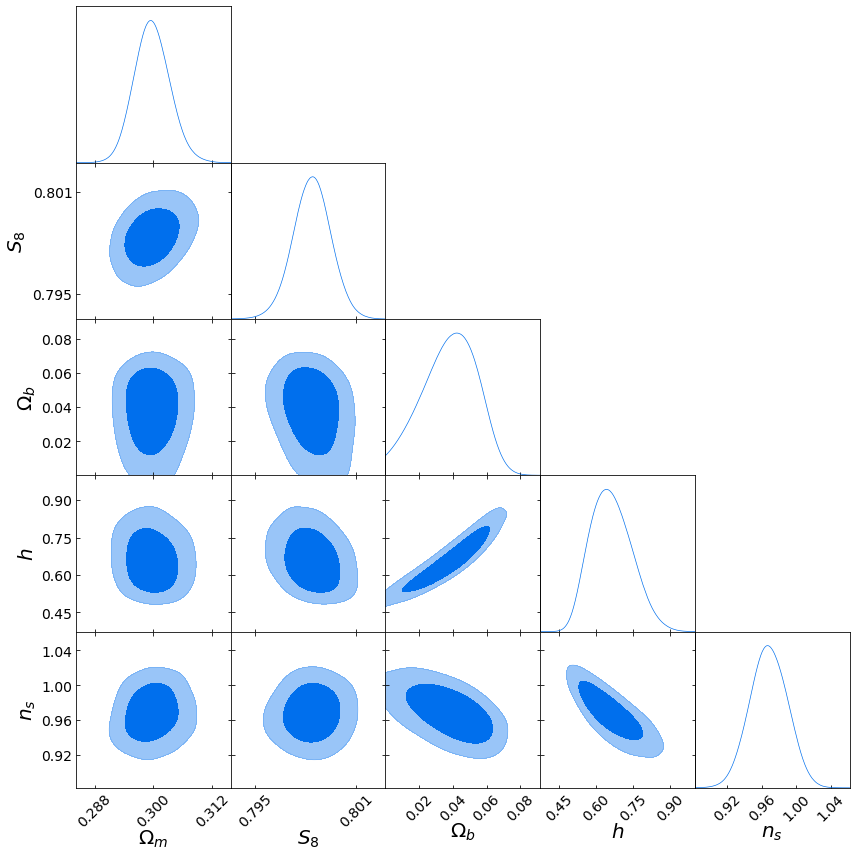

Population 4/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 2250 samples, validate on 250 samples
Epoch 1/100
2250/2250 [==============================] - 3s 1ms/step - loss: 3.6435 - val_loss: 3.7086
Epoch 2/100
2250/2250 [==============================] - 3s 1ms/step - loss: 3.9612 - val_loss: 3.5136
Epoch 3/100
2250/2250 [==============================] - 3s 1ms/step - loss: 3.7741 - val_loss: 3.5308
Epoch 4/100
2250/2250 [==============================] - 3s 1ms/step - loss: 3.7760 - val_loss: 3.4762
Epoch 5/100
2250/2250 [==============================] - 3s 1ms/step - loss: 3.7129 - val_loss: 3.5281
Epoch 6/100
2250/2250 [==============================] - 3s 1ms/step - loss: 3.6911 - val_loss: 3.5432
Epoch 7/100
2250/2250 [==============================] - 3s 1ms/step - loss: 3.6599 - val_loss: 3.5897
Epoch 8/100
2250/2250 [==============================] - 3s 1ms/step - loss: 3.6631 - val_loss: 3.4754
Epoch 9/100
2250/2250 [=============================

Epoch 24/100
2250/2250 [==============================] - 4s 2ms/step - loss: 3.4951 - val_loss: 3.3944
Epoch 25/100
2250/2250 [==============================] - 4s 2ms/step - loss: 3.4975 - val_loss: 3.3891
Epoch 26/100
2250/2250 [==============================] - 4s 2ms/step - loss: 3.4947 - val_loss: 3.3878
Epoch 27/100
2250/2250 [==============================] - 4s 2ms/step - loss: 3.4941 - val_loss: 3.3874
Epoch 28/100
2250/2250 [==============================] - 4s 2ms/step - loss: 3.4931 - val_loss: 3.3895
Epoch 29/100
2250/2250 [==============================] - 4s 2ms/step - loss: 3.4940 - val_loss: 3.3879
Epoch 30/100
2250/2250 [==============================] - 4s 2ms/step - loss: 3.4915 - val_loss: 3.3890
Epoch 31/100
2250/2250 [==============================] - 4s 2ms/step - loss: 3.4913 - val_loss: 3.3915
Epoch 32/100
2250/2250 [==============================] - 5s 2ms/step - loss: 3.4912 - val_loss: 3.3956
Epoch 33/100
2250/2250 [==============================] - 4s 2ms

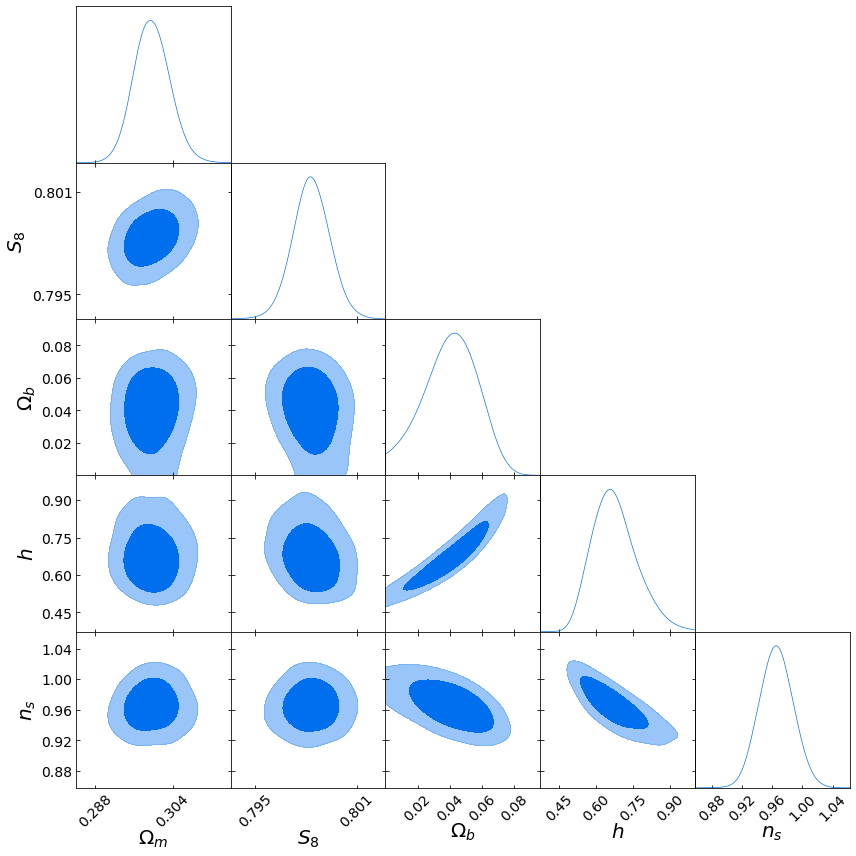

Population 5/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 2700 samples, validate on 300 samples
Epoch 1/100
2700/2700 [==============================] - 4s 1ms/step - loss: 3.5957 - val_loss: 3.4436
Epoch 2/100
2700/2700 [==============================] - 4s 1ms/step - loss: 3.7055 - val_loss: 3.6473
Epoch 3/100
2700/2700 [==============================] - 4s 1ms/step - loss: 3.7019 - val_loss: 3.5583
Epoch 4/100
2700/2700 [==============================] - 4s 1ms/step - loss: 3.6407 - val_loss: 3.4872
Epoch 5/100
2700/2700 [==============================] - 4s 1ms/step - loss: 3.5736 - val_loss: 3.4631
Epoch 6/100
2700/2700 [==============================] - 4s 1ms/step - loss: 3.6534 - val_loss: 4.1137
Epoch 7/100
2700/2700 [==============================] - 4s 1ms/step - loss: 3.6188 - val_loss: 3.4519
Epoch 8/100
2700/2700 [==============================] - 4s 1ms/step - loss: 3.5759 - val_loss: 3.3968
Epoch 9/100
2700/2700 [=============================

Epoch 29/100
2700/2700 [==============================] - 6s 2ms/step - loss: 3.4631 - val_loss: 3.3562
Epoch 30/100
2700/2700 [==============================] - 6s 2ms/step - loss: 3.4669 - val_loss: 3.3501
Epoch 31/100
2700/2700 [==============================] - 6s 2ms/step - loss: 3.4623 - val_loss: 3.3498
Epoch 32/100
2700/2700 [==============================] - 6s 2ms/step - loss: 3.4651 - val_loss: 3.3441
Epoch 33/100
2700/2700 [==============================] - 6s 2ms/step - loss: 3.4606 - val_loss: 3.3483
Epoch 34/100
2700/2700 [==============================] - 6s 2ms/step - loss: 3.4641 - val_loss: 3.3403
Epoch 35/100
2700/2700 [==============================] - 6s 2ms/step - loss: 3.4600 - val_loss: 3.3401
Epoch 36/100
2700/2700 [==============================] - 6s 2ms/step - loss: 3.4625 - val_loss: 3.3369
Epoch 37/100
2700/2700 [==============================] - 6s 2ms/step - loss: 3.4587 - val_loss: 3.3424
Epoch 38/100
2700/2700 [==============================] - 6s 2ms

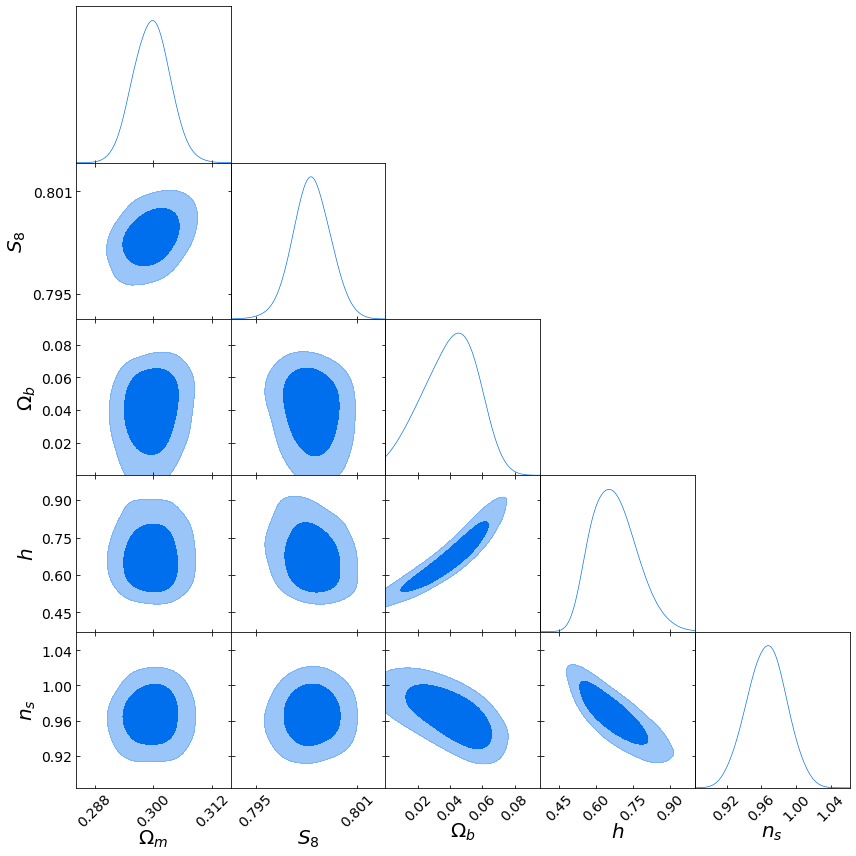

Population 6/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 3150 samples, validate on 350 samples
Epoch 1/100
3150/3150 [==============================] - 5s 1ms/step - loss: 3.5312 - val_loss: 3.9586
Epoch 2/100
3150/3150 [==============================] - 5s 1ms/step - loss: 3.5671 - val_loss: 3.7989
Epoch 3/100
3150/3150 [==============================] - 5s 1ms/step - loss: 3.5813 - val_loss: 3.9259
Epoch 4/100
3150/3150 [==============================] - 5s 1ms/step - loss: 3.6253 - val_loss: 3.9025
Epoch 5/100
3150/3150 [==============================] - 5s 1ms/step - loss: 3.6202 - val_loss: 3.8889
Epoch 6/100
3150/3150 [==============================] - 5s 2ms/step - loss: 3.5653 - val_loss: 3.9925
Epoch 7/100
3150/3150 [==============================] - 7s 2ms/step - loss: 3.5885 - val_loss: 4.0733
Epoch 8/100
3150/3150 [==============================] - 5s 2ms/step - loss: 3.7460 - val_loss: 3.9442
Epoch 9/100
3150/3150 [=============================

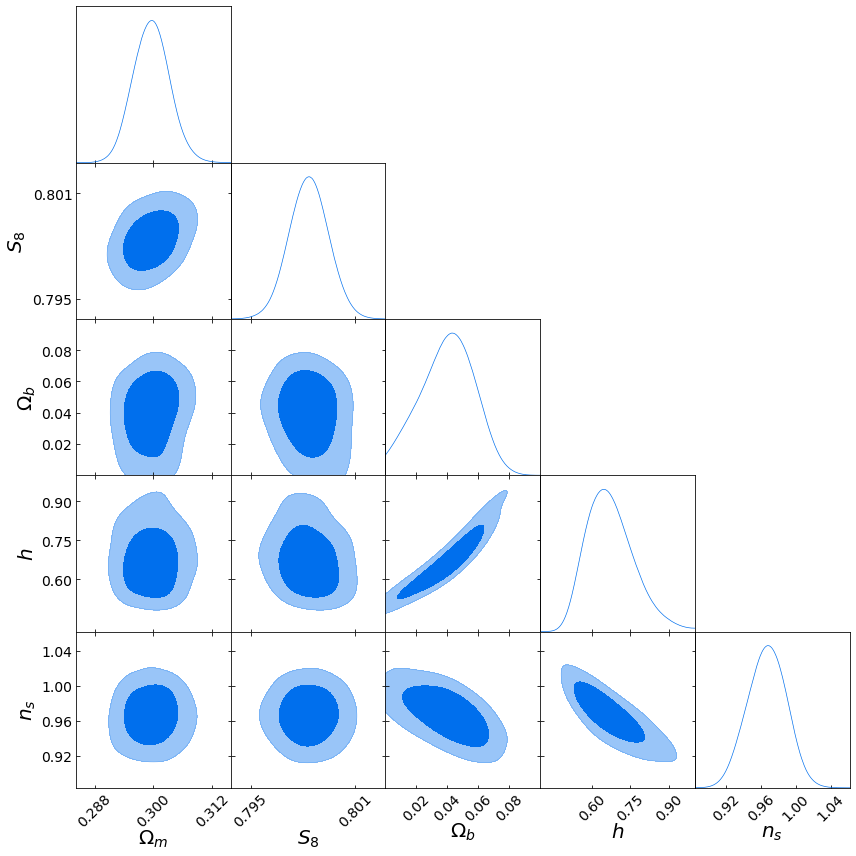

Population 7/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 3600 samples, validate on 400 samples
Epoch 1/100
3600/3600 [==============================] - 5s 1ms/step - loss: 3.5453 - val_loss: 3.6328
Epoch 2/100
3600/3600 [==============================] - 5s 1ms/step - loss: 3.5773 - val_loss: 3.7252
Epoch 3/100
3600/3600 [==============================] - 5s 1ms/step - loss: 3.6041 - val_loss: 4.0322
Epoch 4/100
3600/3600 [==============================] - 5s 1ms/step - loss: 3.5805 - val_loss: 3.7410
Epoch 5/100
3600/3600 [==============================] - 6s 2ms/step - loss: 3.6464 - val_loss: 3.7734
Epoch 6/100
3600/3600 [==============================] - 6s 2ms/step - loss: 3.6669 - val_loss: 3.7738
Epoch 7/100
3600/3600 [==============================] - 5s 1ms/step - loss: 3.6051 - val_loss: 3.7233
Epoch 8/100
3600/3600 [==============================] - 5s 1ms/step - loss: 3.6204 - val_loss: 3.7423
Epoch 9/100
3600/3600 [=============================

Done.
Saving seq_train_post_7.pdf


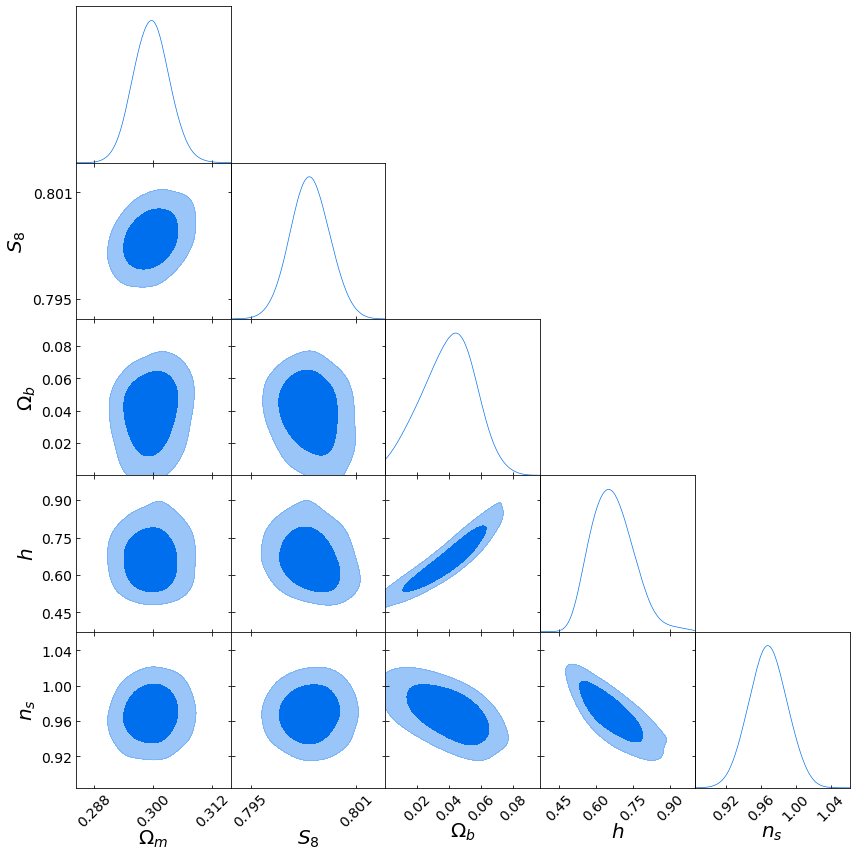

Population 8/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 4050 samples, validate on 450 samples
Epoch 1/100
4050/4050 [==============================] - 6s 1ms/step - loss: 3.5861 - val_loss: 3.5739
Epoch 2/100
4050/4050 [==============================] - 6s 1ms/step - loss: 3.6096 - val_loss: 3.7484
Epoch 3/100
4050/4050 [==============================] - 6s 1ms/step - loss: 3.6505 - val_loss: 3.5472
Epoch 4/100
4050/4050 [==============================] - 6s 1ms/step - loss: 3.5971 - val_loss: 3.7072
Epoch 5/100
4050/4050 [==============================] - 6s 1ms/step - loss: 3.6743 - val_loss: 3.5603
Epoch 6/100
4050/4050 [==============================] - 6s 1ms/step - loss: 3.5867 - val_loss: 3.6038
Epoch 7/100
4050/4050 [==============================] - 6s 1ms/step - loss: 3.6235 - val_loss: 3.6721
Epoch 8/100
4050/4050 [==============================] - 6s 1ms/step - loss: 3.6313 - val_loss: 3.6039
Epoch 9/100
4050/4050 [=============================

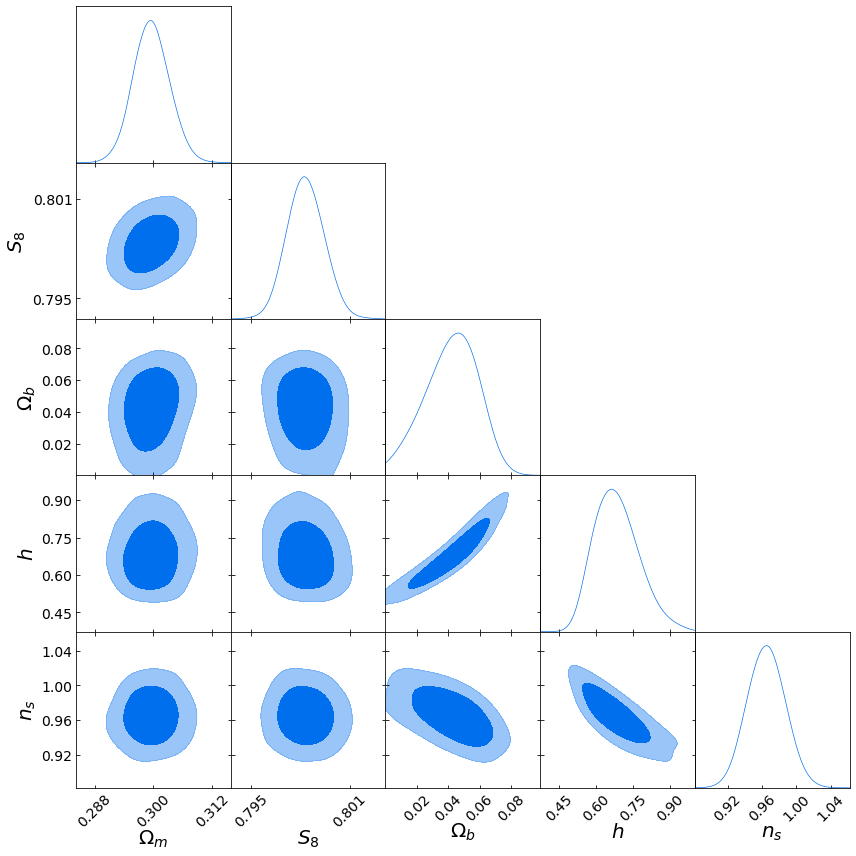

Population 9/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 4500 samples, validate on 500 samples
Epoch 1/100
4500/4500 [==============================] - 6s 1ms/step - loss: 3.5880 - val_loss: 3.6687
Epoch 2/100
4500/4500 [==============================] - 7s 1ms/step - loss: 3.5900 - val_loss: 4.0525
Epoch 3/100
4500/4500 [==============================] - 6s 1ms/step - loss: 3.7304 - val_loss: 3.5421
Epoch 4/100
4500/4500 [==============================] - 7s 1ms/step - loss: 3.6634 - val_loss: 3.6385
Epoch 5/100
4500/4500 [==============================] - 7s 2ms/step - loss: 3.6697 - val_loss: 3.5349
Epoch 6/100
4500/4500 [==============================] - 7s 1ms/step - loss: 3.5942 - val_loss: 3.4869
Epoch 7/100
4500/4500 [==============================] - 7s 1ms/step - loss: 3.5965 - val_loss: 3.6463
Epoch 8/100
4500/4500 [==============================] - 7s 2ms/step - loss: 3.6033 - val_loss: 3.5271
Epoch 9/100
4500/4500 [=============================

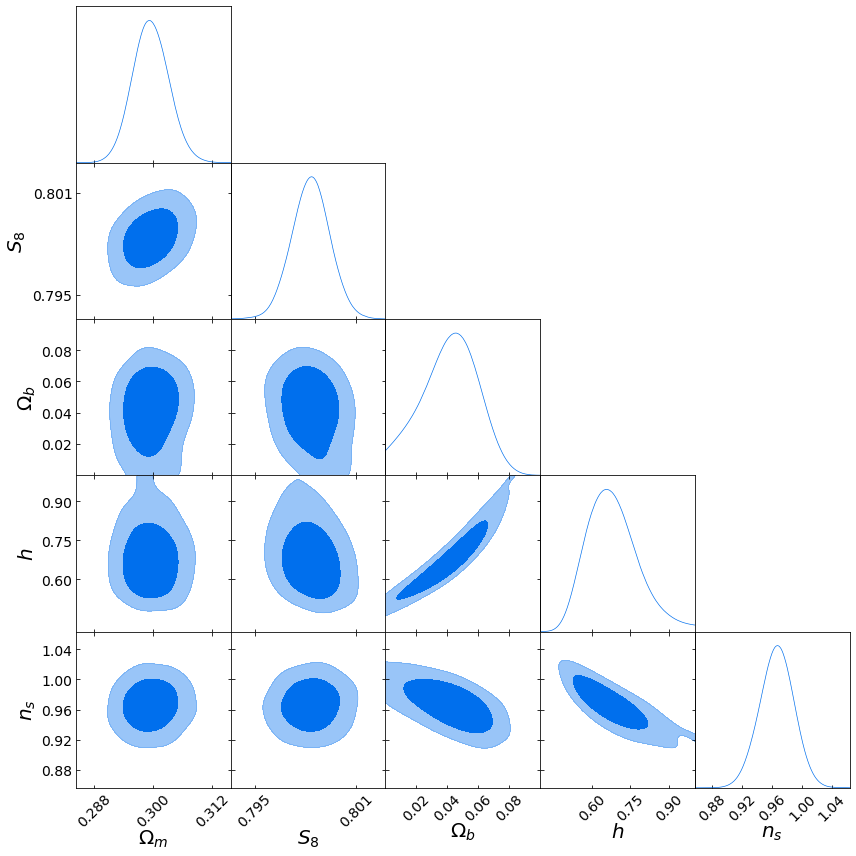

Population 10/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 4950 samples, validate on 550 samples
Epoch 1/100
4950/4950 [==============================] - 7s 1ms/step - loss: 3.6227 - val_loss: 3.8565
Epoch 2/100
4950/4950 [==============================] - 7s 1ms/step - loss: 3.6324 - val_loss: 3.7317
Epoch 3/100
4950/4950 [==============================] - 7s 1ms/step - loss: 3.5821 - val_loss: 3.8521
Epoch 4/100
4950/4950 [==============================] - 7s 1ms/step - loss: 3.6171 - val_loss: 3.7401
Epoch 5/100
4950/4950 [==============================] - 7s 1ms/step - loss: 3.6108 - val_loss: 3.7387
Epoch 6/100
4950/4950 [==============================] - 7s 1ms/step - loss: 3.5944 - val_loss: 3.7456
Epoch 7/100
4950/4950 [==============================] - 7s 1ms/step - loss: 3.7092 - val_loss: 3.8692
Epoch 8/100
4950/4950 [==============================] - 7s 1ms/step - loss: 3.6253 - val_loss: 3.8052
Epoch 9/100
4950/4950 [============================

4950/4950 [==============================] - 13s 3ms/step - loss: 3.4493 - val_loss: 3.6267
Epoch 30/100
4950/4950 [==============================] - 13s 3ms/step - loss: 3.4464 - val_loss: 3.6272
Epoch 31/100
4950/4950 [==============================] - 13s 3ms/step - loss: 3.4472 - val_loss: 3.6249
Epoch 32/100
4950/4950 [==============================] - 14s 3ms/step - loss: 3.4460 - val_loss: 3.6243
Epoch 33/100
4950/4950 [==============================] - 14s 3ms/step - loss: 3.4468 - val_loss: 3.6231
Epoch 34/100
4950/4950 [==============================] - 13s 3ms/step - loss: 3.4450 - val_loss: 3.6227
Epoch 35/100
4950/4950 [==============================] - 14s 3ms/step - loss: 3.4446 - val_loss: 3.6233
Epoch 36/100
4950/4950 [==============================] - 13s 3ms/step - loss: 3.4449 - val_loss: 3.6263
Epoch 37/100
4950/4950 [==============================] - 14s 3ms/step - loss: 3.4452 - val_loss: 3.6275
Epoch 38/100
4950/4950 [==============================] - 13s 3ms/st

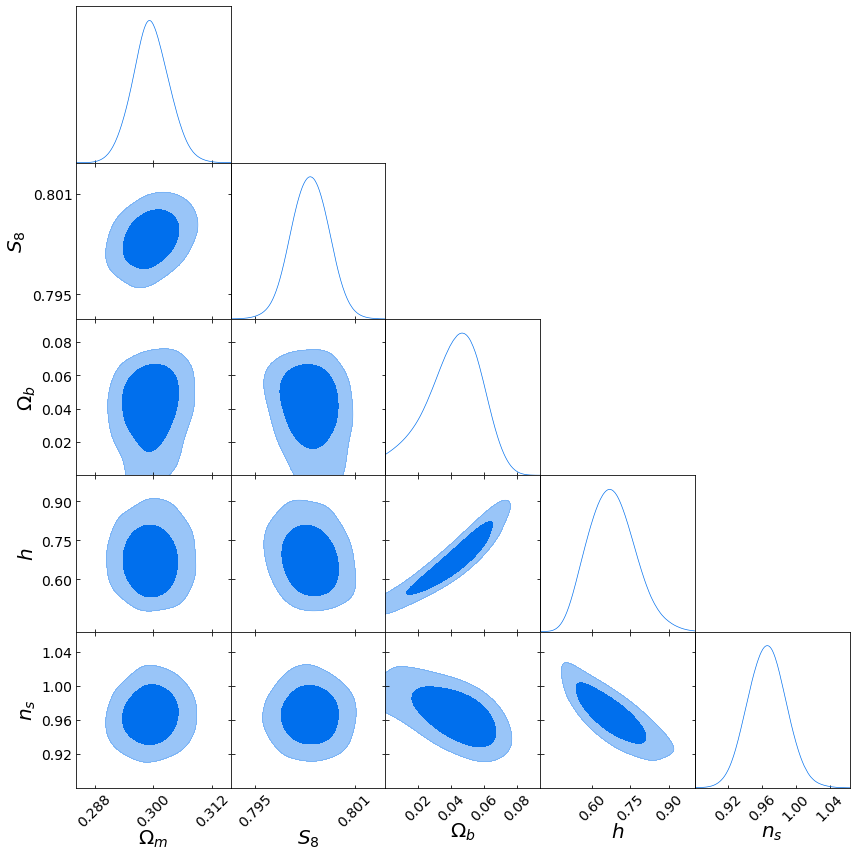

Population 11/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 5400 samples, validate on 600 samples
Epoch 1/100
5400/5400 [==============================] - 8s 1ms/step - loss: 3.6185 - val_loss: 3.6484
Epoch 2/100
5400/5400 [==============================] - 8s 1ms/step - loss: 3.6006 - val_loss: 3.6403
Epoch 3/100
5400/5400 [==============================] - 8s 1ms/step - loss: 3.6170 - val_loss: 3.6445
Epoch 4/100
5400/5400 [==============================] - 8s 1ms/step - loss: 3.6101 - val_loss: 3.5696
Epoch 5/100
5400/5400 [==============================] - 8s 1ms/step - loss: 3.6065 - val_loss: 3.5781
Epoch 6/100
5400/5400 [==============================] - 8s 1ms/step - loss: 3.6336 - val_loss: 3.5668
Epoch 7/100
5400/5400 [==============================] - 8s 1ms/step - loss: 3.6455 - val_loss: 3.6409
Epoch 8/100
5400/5400 [==============================] - 8s 1ms/step - loss: 3.5840 - val_loss: 3.5987
Epoch 9/100
5400/5400 [============================

Epoch 47/100
5400/5400 [==============================] - 14s 3ms/step - loss: 3.4440 - val_loss: 3.5282
Epoch 48/100
5400/5400 [==============================] - 14s 3ms/step - loss: 3.4452 - val_loss: 3.5262
Epoch 49/100
5400/5400 [==============================] - 14s 3ms/step - loss: 3.4441 - val_loss: 3.5246
Epoch 50/100
5400/5400 [==============================] - 14s 3ms/step - loss: 3.4448 - val_loss: 3.5238
Epoch 51/100
5400/5400 [==============================] - 14s 3ms/step - loss: 3.4439 - val_loss: 3.5253
Epoch 52/100
5400/5400 [==============================] - 14s 3ms/step - loss: 3.4442 - val_loss: 3.5235
Epoch 53/100
5400/5400 [==============================] - 14s 3ms/step - loss: 3.4439 - val_loss: 3.5210
Epoch 54/100
5400/5400 [==============================] - 14s 3ms/step - loss: 3.4439 - val_loss: 3.5214
Epoch 55/100
5400/5400 [==============================] - 14s 3ms/step - loss: 3.4438 - val_loss: 3.5239
Epoch 56/100
5400/5400 [==============================]

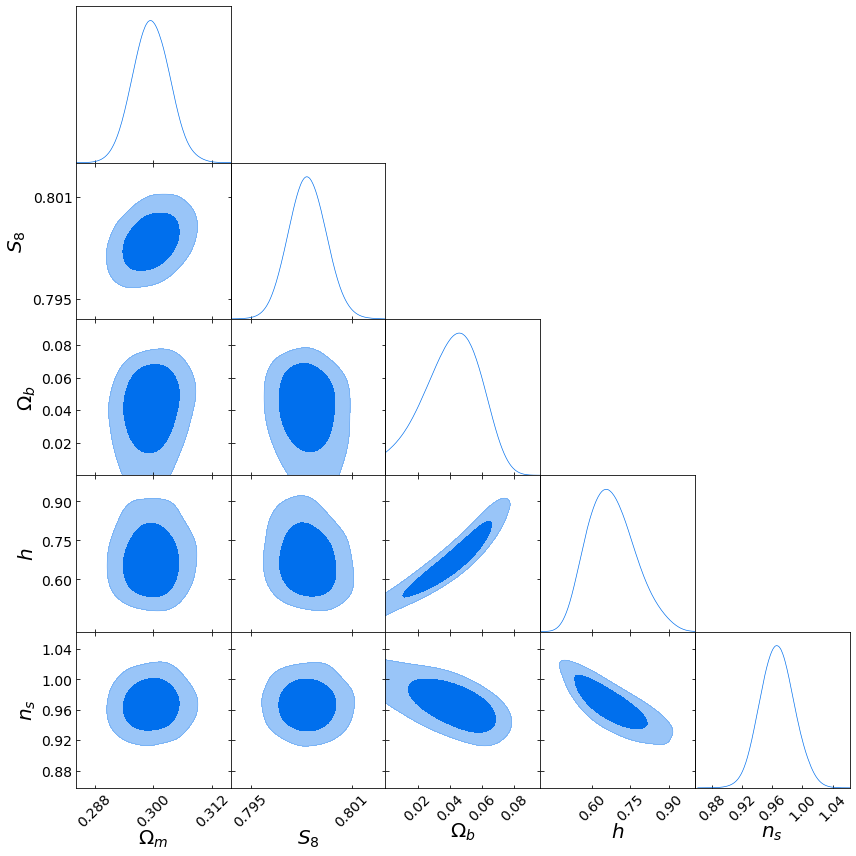

Population 12/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 5850 samples, validate on 650 samples
Epoch 1/100
5850/5850 [==============================] - 8s 1ms/step - loss: 3.5325 - val_loss: 3.6798
Epoch 2/100
5850/5850 [==============================] - 8s 1ms/step - loss: 3.6270 - val_loss: 3.6223
Epoch 3/100
5850/5850 [==============================] - 8s 1ms/step - loss: 3.6217 - val_loss: 3.5645
Epoch 4/100
5850/5850 [==============================] - 8s 1ms/step - loss: 3.5764 - val_loss: 3.5710
Epoch 5/100
5850/5850 [==============================] - 8s 1ms/step - loss: 3.5917 - val_loss: 3.5636
Epoch 6/100
5850/5850 [==============================] - 8s 1ms/step - loss: 3.5520 - val_loss: 3.7252
Epoch 7/100
5850/5850 [==============================] - 8s 1ms/step - loss: 3.6034 - val_loss: 3.5993
Epoch 8/100
5850/5850 [==============================] - 8s 1ms/step - loss: 3.5685 - val_loss: 3.6333
Epoch 9/100
5850/5850 [============================

Epoch 34/100
5850/5850 [==============================] - 16s 3ms/step - loss: 3.4451 - val_loss: 3.5141
Epoch 35/100
5850/5850 [==============================] - 16s 3ms/step - loss: 3.4448 - val_loss: 3.5146
Epoch 36/100
5850/5850 [==============================] - 16s 3ms/step - loss: 3.4443 - val_loss: 3.5149
Epoch 37/100
5850/5850 [==============================] - 16s 3ms/step - loss: 3.4438 - val_loss: 3.5152
Epoch 38/100
5850/5850 [==============================] - 16s 3ms/step - loss: 3.4437 - val_loss: 3.5156
Epoch 39/100
5850/5850 [==============================] - 16s 3ms/step - loss: 3.4436 - val_loss: 3.5157
Epoch 40/100
5850/5850 [==============================] - 16s 3ms/step - loss: 3.4437 - val_loss: 3.5155
Epoch 41/100
5850/5850 [==============================] - 18s 3ms/step - loss: 3.4436 - val_loss: 3.5152
Epoch 42/100
5850/5850 [==============================] - 16s 3ms/step - loss: 3.4433 - val_loss: 3.5149
Epoch 43/100
5850/5850 [==============================]

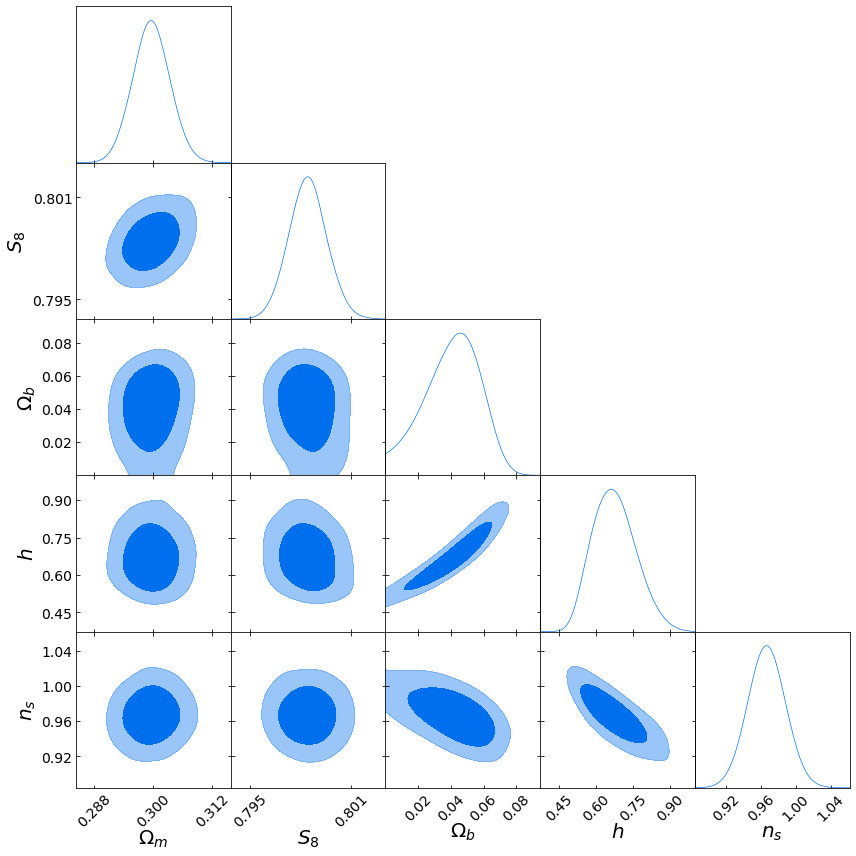

Population 13/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 6300 samples, validate on 700 samples
Epoch 1/100
6300/6300 [==============================] - 8s 1ms/step - loss: 3.6057 - val_loss: 3.8738
Epoch 2/100
6300/6300 [==============================] - 8s 1ms/step - loss: 3.5648 - val_loss: 3.6782
Epoch 3/100
6300/6300 [==============================] - 8s 1ms/step - loss: 3.5959 - val_loss: 3.7351
Epoch 4/100
6300/6300 [==============================] - 8s 1ms/step - loss: 3.5825 - val_loss: 3.6896
Epoch 5/100
6300/6300 [==============================] - 8s 1ms/step - loss: 3.5565 - val_loss: 3.6542
Epoch 6/100
6300/6300 [==============================] - 8s 1ms/step - loss: 3.5563 - val_loss: 3.7610
Epoch 7/100
6300/6300 [==============================] - 8s 1ms/step - loss: 3.6262 - val_loss: 3.8232
Epoch 8/100
6300/6300 [==============================] - 9s 1ms/step - loss: 3.5906 - val_loss: 3.6735
Epoch 9/100
6300/6300 [============================

Epoch 40/100
6300/6300 [==============================] - 18s 3ms/step - loss: 3.4440 - val_loss: 3.6089
Epoch 41/100
6300/6300 [==============================] - 18s 3ms/step - loss: 3.4438 - val_loss: 3.6095
Epoch 42/100
6300/6300 [==============================] - 18s 3ms/step - loss: 3.4441 - val_loss: 3.6001
Epoch 43/100
6300/6300 [==============================] - 18s 3ms/step - loss: 3.4425 - val_loss: 3.5963
Epoch 44/100
6300/6300 [==============================] - 22s 4ms/step - loss: 3.4436 - val_loss: 3.5994
Epoch 45/100
6300/6300 [==============================] - 22s 3ms/step - loss: 3.4425 - val_loss: 3.6068
Epoch 46/100
6300/6300 [==============================] - 20s 3ms/step - loss: 3.4430 - val_loss: 3.6073
Epoch 47/100
6300/6300 [==============================] - 19s 3ms/step - loss: 3.4425 - val_loss: 3.6028
Epoch 48/100
6300/6300 [==============================] - 19s 3ms/step - loss: 3.4421 - val_loss: 3.6023
Epoch 49/100
6300/6300 [==============================]

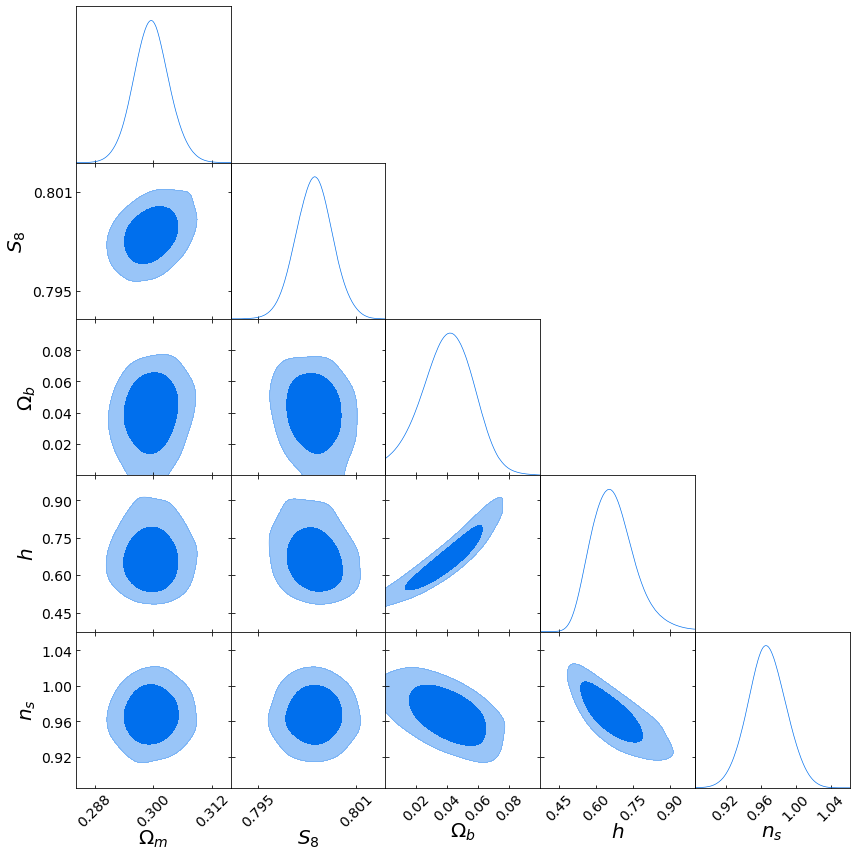

Population 14/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 6750 samples, validate on 750 samples
Epoch 1/100
6750/6750 [==============================] - 9s 1ms/step - loss: 3.5789 - val_loss: 3.5826
Epoch 2/100
6750/6750 [==============================] - 9s 1ms/step - loss: 3.6238 - val_loss: 3.5939
Epoch 3/100
6750/6750 [==============================] - 9s 1ms/step - loss: 3.5894 - val_loss: 3.8789
Epoch 4/100
6750/6750 [==============================] - 9s 1ms/step - loss: 3.6384 - val_loss: 3.5825
Epoch 5/100
6750/6750 [==============================] - 9s 1ms/step - loss: 3.5679 - val_loss: 3.6217
Epoch 6/100
6750/6750 [==============================] - 9s 1ms/step - loss: 3.6191 - val_loss: 3.5967
Epoch 7/100
6750/6750 [==============================] - 9s 1ms/step - loss: 3.5817 - val_loss: 3.6526
Epoch 8/100
6750/6750 [==============================] - 9s 1ms/step - loss: 3.6245 - val_loss: 3.5883
Epoch 9/100
6750/6750 [============================

Epoch 39/100
6750/6750 [==============================] - 20s 3ms/step - loss: 3.4489 - val_loss: 3.5271
Epoch 40/100
6750/6750 [==============================] - 20s 3ms/step - loss: 3.4487 - val_loss: 3.5252
Epoch 41/100
6750/6750 [==============================] - 21s 3ms/step - loss: 3.4485 - val_loss: 3.5241
Epoch 42/100
6750/6750 [==============================] - 20s 3ms/step - loss: 3.4486 - val_loss: 3.5240
Epoch 43/100
6750/6750 [==============================] - 19s 3ms/step - loss: 3.4484 - val_loss: 3.5242
Epoch 44/100
6750/6750 [==============================] - 19s 3ms/step - loss: 3.4484 - val_loss: 3.5234
Epoch 45/100
6750/6750 [==============================] - 19s 3ms/step - loss: 3.4481 - val_loss: 3.5222
Epoch 46/100
6750/6750 [==============================] - 19s 3ms/step - loss: 3.4480 - val_loss: 3.5216
Epoch 47/100
6750/6750 [==============================] - 19s 3ms/step - loss: 3.4478 - val_loss: 3.5213
Epoch 48/100
6750/6750 [==============================]

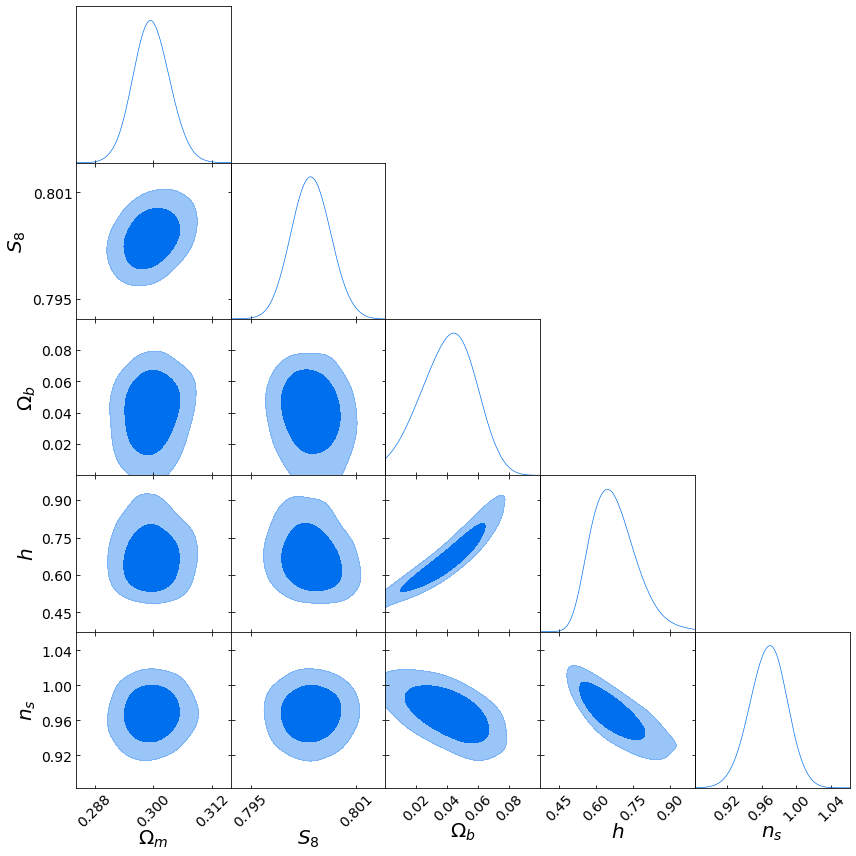

Population 15/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 7200 samples, validate on 800 samples
Epoch 1/100
7200/7200 [==============================] - 10s 1ms/step - loss: 3.5938 - val_loss: 3.6420
Epoch 2/100
7200/7200 [==============================] - 10s 1ms/step - loss: 3.5768 - val_loss: 3.6751
Epoch 3/100
7200/7200 [==============================] - 10s 1ms/step - loss: 3.5637 - val_loss: 3.6606
Epoch 4/100
7200/7200 [==============================] - 10s 1ms/step - loss: 3.5800 - val_loss: 3.6690
Epoch 5/100
7200/7200 [==============================] - 10s 1ms/step - loss: 3.5976 - val_loss: 3.6418
Epoch 6/100
7200/7200 [==============================] - 10s 1ms/step - loss: 3.5905 - val_loss: 3.6738
Epoch 7/100
7200/7200 [==============================] - 10s 1ms/step - loss: 3.5966 - val_loss: 3.5924
Epoch 8/100
7200/7200 [==============================] - 10s 1ms/step - loss: 3.5752 - val_loss: 3.6990
Epoch 9/100
7200/7200 [====================

Epoch 51/100
7200/7200 [==============================] - 24s 3ms/step - loss: 3.4463 - val_loss: 3.5692
Epoch 52/100
7200/7200 [==============================] - 24s 3ms/step - loss: 3.4466 - val_loss: 3.5687
Epoch 53/100
7200/7200 [==============================] - 24s 3ms/step - loss: 3.4461 - val_loss: 3.5689
Epoch 54/100
7200/7200 [==============================] - 24s 3ms/step - loss: 3.4462 - val_loss: 3.5690
Epoch 55/100
7200/7200 [==============================] - 24s 3ms/step - loss: 3.4457 - val_loss: 3.5699
Epoch 56/100
7200/7200 [==============================] - 24s 3ms/step - loss: 3.4459 - val_loss: 3.5703
Epoch 57/100
7200/7200 [==============================] - 24s 3ms/step - loss: 3.4459 - val_loss: 3.5702
Epoch 58/100
7200/7200 [==============================] - 25s 3ms/step - loss: 3.4458 - val_loss: 3.5702
Epoch 59/100
7200/7200 [==============================] - 24s 3ms/step - loss: 3.4458 - val_loss: 3.5700
Epoch 60/100
7200/7200 [==============================]

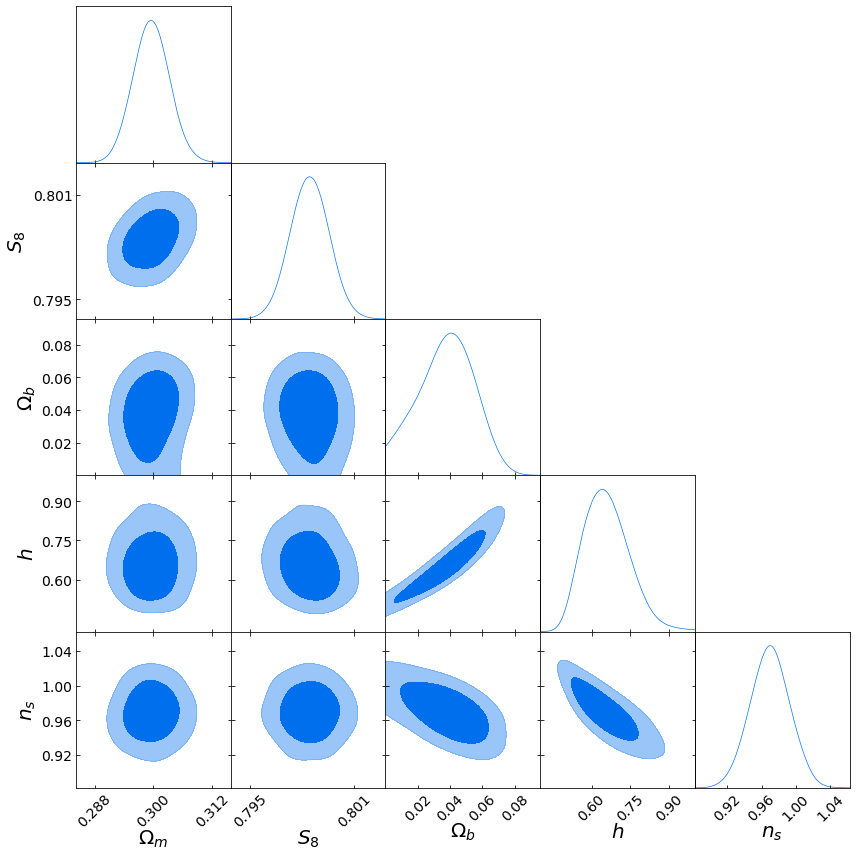

Population 16/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 7650 samples, validate on 850 samples
Epoch 1/100
7650/7650 [==============================] - 12s 2ms/step - loss: 3.5740 - val_loss: 3.6920
Epoch 2/100
7650/7650 [==============================] - 12s 2ms/step - loss: 3.5937 - val_loss: 3.6351
Epoch 3/100
7650/7650 [==============================] - 12s 2ms/step - loss: 3.5465 - val_loss: 3.7477
Epoch 4/100
7650/7650 [==============================] - 12s 2ms/step - loss: 3.5487 - val_loss: 3.5552
Epoch 5/100
7650/7650 [==============================] - 12s 2ms/step - loss: 3.5982 - val_loss: 3.6248
Epoch 6/100
7650/7650 [==============================] - 18s 2ms/step - loss: 3.6136 - val_loss: 3.5898
Epoch 7/100
7650/7650 [==============================] - 12s 2ms/step - loss: 3.5554 - val_loss: 3.5511
Epoch 8/100
7650/7650 [==============================] - 12s 2ms/step - loss: 3.5658 - val_loss: 3.6771
Epoch 9/100
7650/7650 [====================

Epoch 51/100
7650/7650 [==============================] - 24s 3ms/step - loss: 3.4480 - val_loss: 3.5034
Epoch 52/100
7650/7650 [==============================] - 25s 3ms/step - loss: 3.4479 - val_loss: 3.5028
Epoch 53/100
7650/7650 [==============================] - 24s 3ms/step - loss: 3.4478 - val_loss: 3.5021
Epoch 54/100
7650/7650 [==============================] - 23s 3ms/step - loss: 3.4477 - val_loss: 3.5015
Epoch 55/100
7650/7650 [==============================] - 23s 3ms/step - loss: 3.4475 - val_loss: 3.5011
Epoch 56/100
7650/7650 [==============================] - 23s 3ms/step - loss: 3.4475 - val_loss: 3.5008
Epoch 57/100
7650/7650 [==============================] - 24s 3ms/step - loss: 3.4475 - val_loss: 3.5008
Epoch 58/100
7650/7650 [==============================] - 24s 3ms/step - loss: 3.4476 - val_loss: 3.5009
Epoch 59/100
7650/7650 [==============================] - 24s 3ms/step - loss: 3.4475 - val_loss: 3.5011
Epoch 60/100
7650/7650 [==============================]

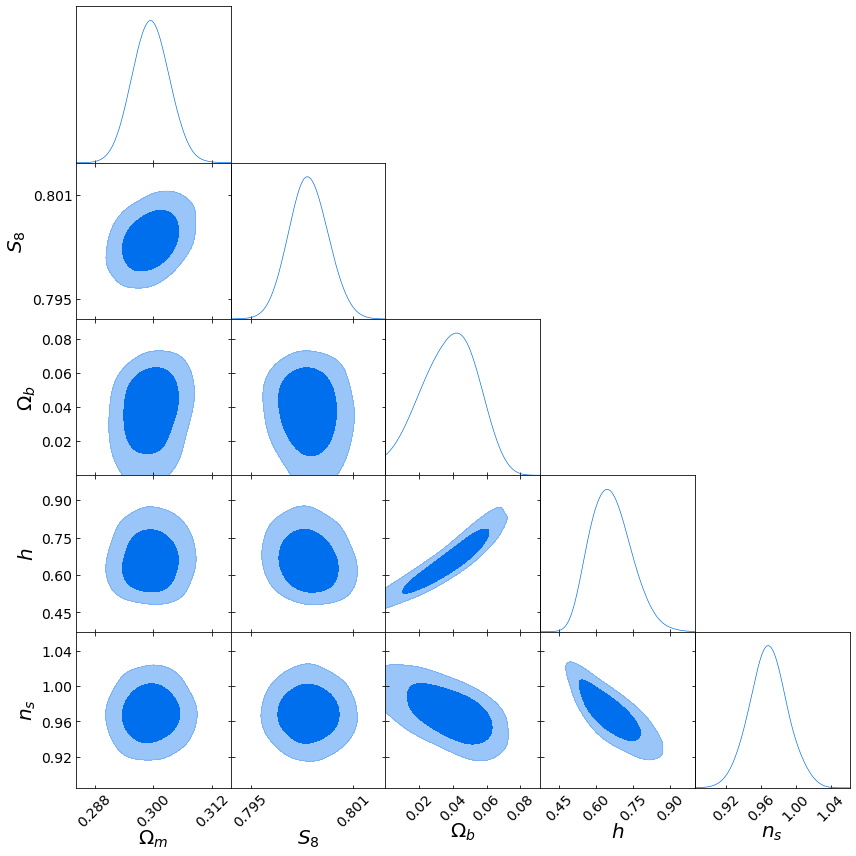

Population 17/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 8100 samples, validate on 900 samples
Epoch 1/100
8100/8100 [==============================] - 11s 1ms/step - loss: 3.5395 - val_loss: 3.5404
Epoch 2/100
8100/8100 [==============================] - 11s 1ms/step - loss: 3.5616 - val_loss: 3.7537
Epoch 3/100
8100/8100 [==============================] - 11s 1ms/step - loss: 3.5650 - val_loss: 3.5088
Epoch 4/100
8100/8100 [==============================] - 11s 1ms/step - loss: 3.5941 - val_loss: 3.5499
Epoch 5/100
8100/8100 [==============================] - 11s 1ms/step - loss: 3.5582 - val_loss: 3.5559
Epoch 6/100
8100/8100 [==============================] - 11s 1ms/step - loss: 3.5978 - val_loss: 3.5792
Epoch 7/100
8100/8100 [==============================] - 11s 1ms/step - loss: 3.5627 - val_loss: 3.6379
Epoch 8/100
8100/8100 [==============================] - 11s 1ms/step - loss: 3.5852 - val_loss: 3.5499
Epoch 9/100
8100/8100 [====================

Epoch 46/100
8100/8100 [==============================] - 25s 3ms/step - loss: 3.4451 - val_loss: 3.4607
Epoch 47/100
8100/8100 [==============================] - 26s 3ms/step - loss: 3.4453 - val_loss: 3.4596
Epoch 48/100
8100/8100 [==============================] - 27s 3ms/step - loss: 3.4448 - val_loss: 3.4589
Epoch 49/100
8100/8100 [==============================] - 28s 3ms/step - loss: 3.4448 - val_loss: 3.4592
Epoch 50/100
8100/8100 [==============================] - 27s 3ms/step - loss: 3.4445 - val_loss: 3.4603
Epoch 51/100
8100/8100 [==============================] - 27s 3ms/step - loss: 3.4445 - val_loss: 3.4605
Epoch 52/100
8100/8100 [==============================] - 27s 3ms/step - loss: 3.4445 - val_loss: 3.4597
Epoch 53/100
8100/8100 [==============================] - 27s 3ms/step - loss: 3.4444 - val_loss: 3.4595
Epoch 54/100
8100/8100 [==============================] - 27s 3ms/step - loss: 3.4444 - val_loss: 3.4598
Epoch 55/100
8100/8100 [==============================]

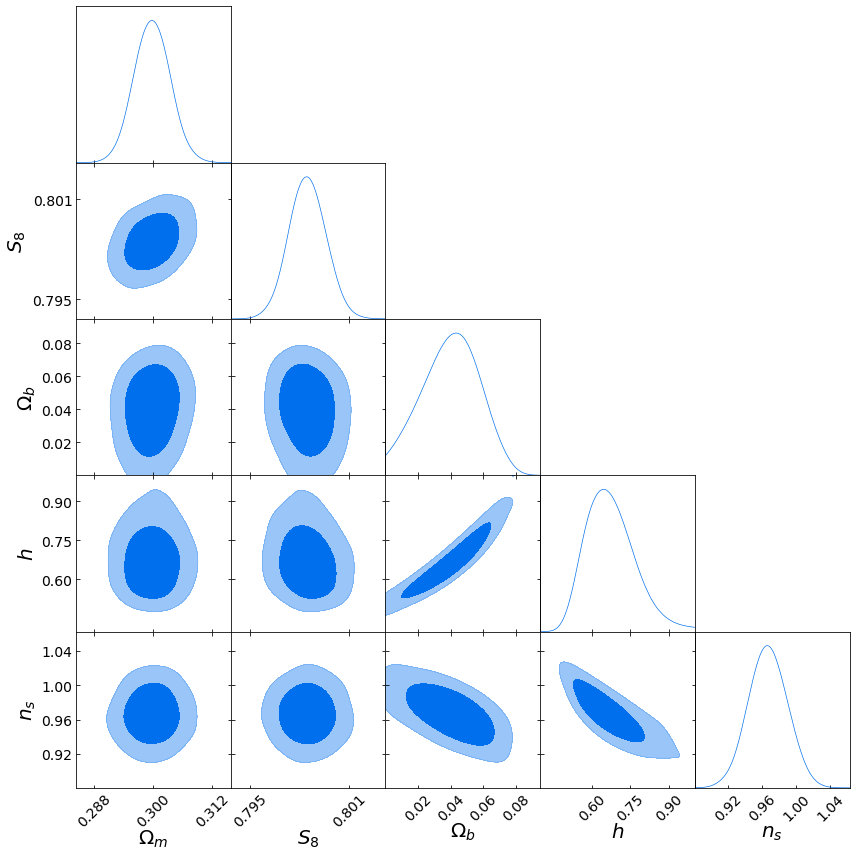

Population 18/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 8550 samples, validate on 950 samples
Epoch 1/100
8550/8550 [==============================] - 21s 3ms/step - loss: 3.5398 - val_loss: 3.6251
Epoch 2/100
8550/8550 [==============================] - 41s 5ms/step - loss: 3.6067 - val_loss: 3.6379
Epoch 3/100
8550/8550 [==============================] - 30s 4ms/step - loss: 3.6151 - val_loss: 3.9714
Epoch 4/100
8550/8550 [==============================] - 19s 2ms/step - loss: 3.6046 - val_loss: 3.6470
Epoch 5/100
8550/8550 [==============================] - 18s 2ms/step - loss: 3.5693 - val_loss: 3.7724
Epoch 6/100
8550/8550 [==============================] - 15s 2ms/step - loss: 3.5944 - val_loss: 3.5977
Epoch 7/100
8550/8550 [==============================] - 15s 2ms/step - loss: 3.5491 - val_loss: 3.6203
Epoch 8/100
8550/8550 [==============================] - 16s 2ms/step - loss: 3.5651 - val_loss: 3.6464
Epoch 9/100
8550/8550 [====================

Epoch 30/100
8550/8550 [==============================] - 30s 3ms/step - loss: 3.4475 - val_loss: 3.5479
Epoch 31/100
8550/8550 [==============================] - 32s 4ms/step - loss: 3.4462 - val_loss: 3.5475
Epoch 32/100
8550/8550 [==============================] - 30s 3ms/step - loss: 3.4434 - val_loss: 3.5501
Epoch 33/100
8550/8550 [==============================] - 29s 3ms/step - loss: 3.4428 - val_loss: 3.5527
Epoch 34/100
8550/8550 [==============================] - 29s 3ms/step - loss: 3.4434 - val_loss: 3.5535
Epoch 35/100
8550/8550 [==============================] - 29s 3ms/step - loss: 3.4435 - val_loss: 3.5543
Epoch 36/100
8550/8550 [==============================] - 31s 4ms/step - loss: 3.4442 - val_loss: 3.5531
Epoch 37/100
8550/8550 [==============================] - 30s 3ms/step - loss: 3.4431 - val_loss: 3.5510
Epoch 38/100
8550/8550 [==============================] - 35s 4ms/step - loss: 3.4417 - val_loss: 3.5486
Epoch 39/100
8550/8550 [==============================]

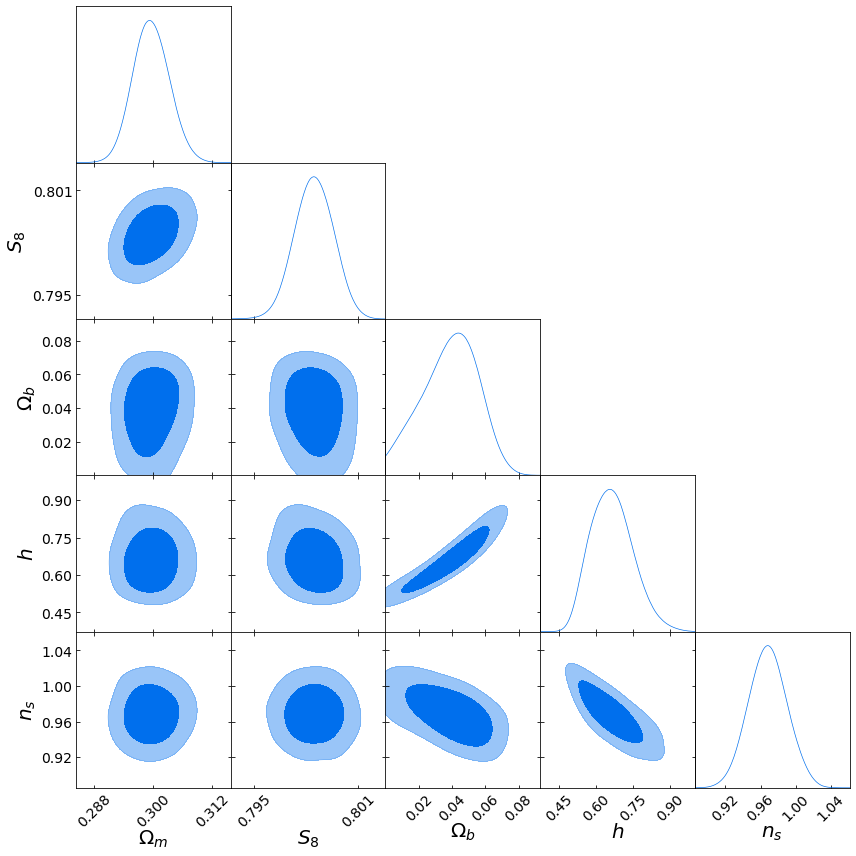

Population 19/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 9000 samples, validate on 1000 samples
Epoch 1/100
9000/9000 [==============================] - 17s 2ms/step - loss: 3.5620 - val_loss: 3.5958
Epoch 2/100
9000/9000 [==============================] - 44s 5ms/step - loss: 3.5802 - val_loss: 3.4761
Epoch 3/100
9000/9000 [==============================] - 32s 4ms/step - loss: 3.5629 - val_loss: 3.6149
Epoch 4/100
9000/9000 [==============================] - 21s 2ms/step - loss: 3.5417 - val_loss: 3.5316
Epoch 5/100
9000/9000 [==============================] - 16s 2ms/step - loss: 3.6143 - val_loss: 3.4902
Epoch 6/100
9000/9000 [==============================] - 18s 2ms/step - loss: 3.5486 - val_loss: 3.5005
Epoch 7/100
9000/9000 [==============================] - 16s 2ms/step - loss: 3.5643 - val_loss: 3.5704
Epoch 8/100
9000/9000 [==============================] - 17s 2ms/step - loss: 3.6059 - val_loss: 3.8587
Epoch 9/100
9000/9000 [===================

Epoch 48/100
9000/9000 [==============================] - 36s 4ms/step - loss: 3.4376 - val_loss: 3.4286
Epoch 49/100
9000/9000 [==============================] - 35s 4ms/step - loss: 3.4378 - val_loss: 3.4290
Epoch 50/100
9000/9000 [==============================] - 33s 4ms/step - loss: 3.4374 - val_loss: 3.4305
Epoch 51/100
9000/9000 [==============================] - 35s 4ms/step - loss: 3.4369 - val_loss: 3.4321
Epoch 52/100
9000/9000 [==============================] - 33s 4ms/step - loss: 3.4373 - val_loss: 3.4313
Epoch 53/100
9000/9000 [==============================] - 34s 4ms/step - loss: 3.4370 - val_loss: 3.4302
Epoch 54/100
9000/9000 [==============================] - 34s 4ms/step - loss: 3.4371 - val_loss: 3.4299
Epoch 55/100
9000/9000 [==============================] - 36s 4ms/step - loss: 3.4372 - val_loss: 3.4301
Epoch 56/100
9000/9000 [==============================] - 36s 4ms/step - loss: 3.4368 - val_loss: 3.4307
Epoch 57/100
9000/9000 [==============================]

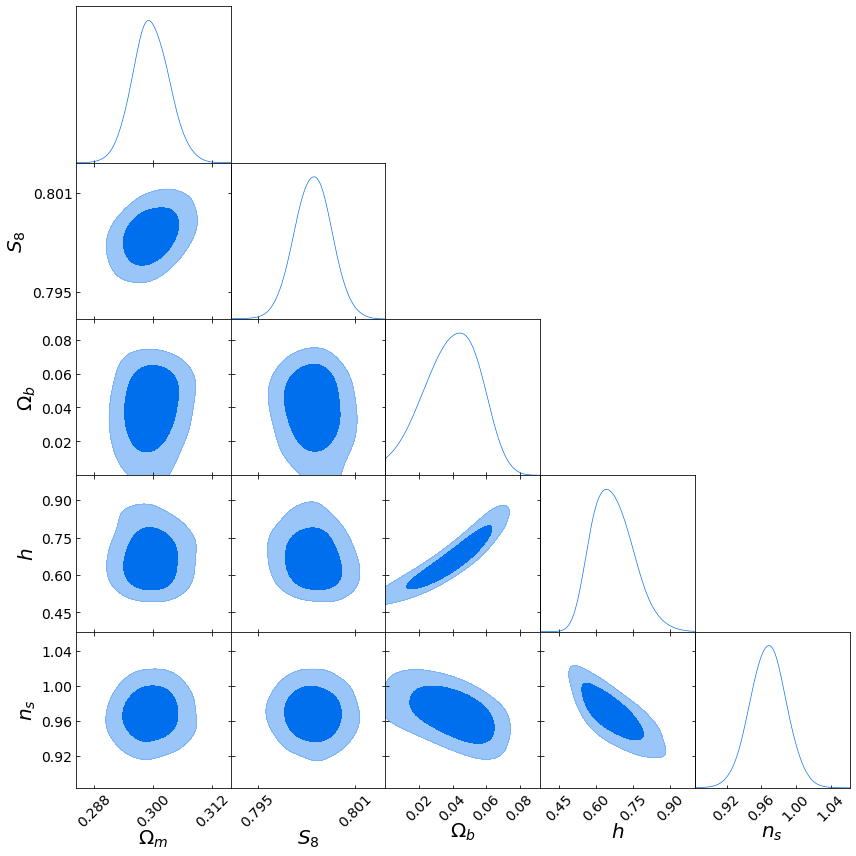

Population 20/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 9450 samples, validate on 1050 samples
Epoch 1/100
9450/9450 [==============================] - 19s 2ms/step - loss: 3.5418 - val_loss: 3.3410
Epoch 2/100
9450/9450 [==============================] - 22s 2ms/step - loss: 3.5720 - val_loss: 3.6053
Epoch 3/100
9450/9450 [==============================] - 18s 2ms/step - loss: 3.5724 - val_loss: 3.3579
Epoch 4/100
9450/9450 [==============================] - 18s 2ms/step - loss: 3.5882 - val_loss: 3.4076
Epoch 5/100
9450/9450 [==============================] - 17s 2ms/step - loss: 3.5771 - val_loss: 3.4448
Epoch 6/100
9450/9450 [==============================] - 19s 2ms/step - loss: 3.5716 - val_loss: 3.4730
Epoch 7/100
9450/9450 [==============================] - 17s 2ms/step - loss: 3.5579 - val_loss: 3.3655
Epoch 8/100
9450/9450 [==============================] - 20s 2ms/step - loss: 3.5675 - val_loss: 3.3521
Epoch 9/100
9450/9450 [===================

Epoch 16/100
9450/9450 [==============================] - 38s 4ms/step - loss: 3.4566 - val_loss: 3.3061
Epoch 17/100
9450/9450 [==============================] - 48s 5ms/step - loss: 3.4529 - val_loss: 3.2991
Epoch 18/100
9450/9450 [==============================] - 43s 5ms/step - loss: 3.4500 - val_loss: 3.2955
Epoch 19/100
9450/9450 [==============================] - 41s 4ms/step - loss: 3.4508 - val_loss: 3.2944
Epoch 20/100
9450/9450 [==============================] - 38s 4ms/step - loss: 3.4517 - val_loss: 3.2946
Epoch 21/100
9450/9450 [==============================] - 35s 4ms/step - loss: 3.4508 - val_loss: 3.2946
Epoch 22/100
9450/9450 [==============================] - 48s 5ms/step - loss: 3.4489 - val_loss: 3.2926
Epoch 23/100
9450/9450 [==============================] - 37s 4ms/step - loss: 3.4461 - val_loss: 3.2910
Epoch 24/100
9450/9450 [==============================] - 43s 5ms/step - loss: 3.4451 - val_loss: 3.2915
Epoch 25/100
9450/9450 [==============================]

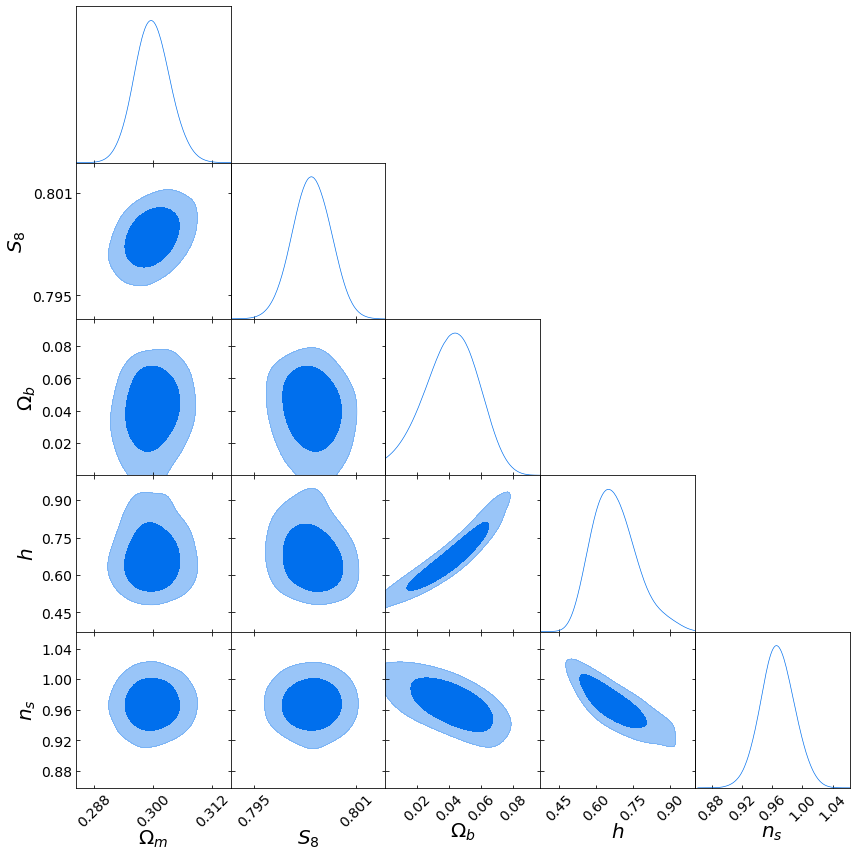

Population 21/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 9900 samples, validate on 1100 samples
Epoch 1/100
9900/9900 [==============================] - 17s 2ms/step - loss: 3.5241 - val_loss: 3.4088
Epoch 2/100
9900/9900 [==============================] - 16s 2ms/step - loss: 3.5362 - val_loss: 3.3968
Epoch 3/100
9900/9900 [==============================] - 17s 2ms/step - loss: 3.5334 - val_loss: 3.4364
Epoch 4/100
9900/9900 [==============================] - 17s 2ms/step - loss: 3.5226 - val_loss: 3.4184
Epoch 5/100
9900/9900 [==============================] - 17s 2ms/step - loss: 3.5368 - val_loss: 3.4531
Epoch 6/100
9900/9900 [==============================] - 17s 2ms/step - loss: 3.5752 - val_loss: 3.5215
Epoch 7/100
9900/9900 [==============================] - 18s 2ms/step - loss: 3.5410 - val_loss: 3.4324
Epoch 8/100
9900/9900 [==============================] - 17s 2ms/step - loss: 3.5347 - val_loss: 3.4019
Epoch 9/100
9900/9900 [===================

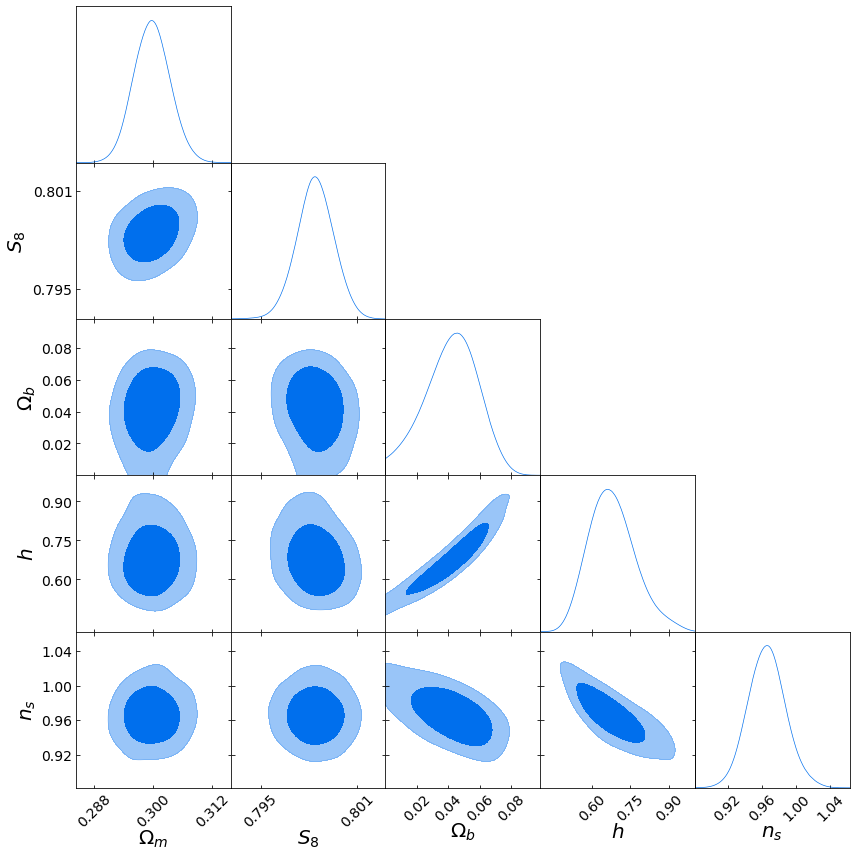

Population 22/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 10350 samples, validate on 1150 samples
Epoch 1/100
10350/10350 [==============================] - 14s 1ms/step - loss: 3.5428 - val_loss: 3.5637
Epoch 2/100
10350/10350 [==============================] - 14s 1ms/step - loss: 3.5223 - val_loss: 3.6071
Epoch 3/100
10350/10350 [==============================] - 14s 1ms/step - loss: 3.5656 - val_loss: 3.5818
Epoch 4/100
10350/10350 [==============================] - 14s 1ms/step - loss: 3.5234 - val_loss: 3.6178
Epoch 5/100
10350/10350 [==============================] - 14s 1ms/step - loss: 3.5448 - val_loss: 3.6034
Epoch 6/100
10350/10350 [==============================] - 14s 1ms/step - loss: 3.5433 - val_loss: 3.5234
Epoch 7/100
10350/10350 [==============================] - 14s 1ms/step - loss: 3.5285 - val_loss: 3.6030
Epoch 8/100
10350/10350 [==============================] - 14s 1ms/step - loss: 3.5212 - val_loss: 3.5440
Epoch 9/100
10350/10350 [

10350/10350 [==============================] - 49s 5ms/step - loss: 3.4233 - val_loss: 3.4979
Epoch 42/100
10350/10350 [==============================] - 79s 8ms/step - loss: 3.4216 - val_loss: 3.4958
Epoch 43/100
10350/10350 [==============================] - 65s 6ms/step - loss: 3.4209 - val_loss: 3.4961
Epoch 44/100
10350/10350 [==============================] - 50s 5ms/step - loss: 3.4221 - val_loss: 3.4962
Epoch 45/100
10350/10350 [==============================] - 48s 5ms/step - loss: 3.4206 - val_loss: 3.4989
Epoch 46/100
10350/10350 [==============================] - 48s 5ms/step - loss: 3.4213 - val_loss: 3.4988
Epoch 47/100
10350/10350 [==============================] - 48s 5ms/step - loss: 3.4213 - val_loss: 3.4957
Epoch 48/100
10350/10350 [==============================] - 49s 5ms/step - loss: 3.4201 - val_loss: 3.4947
Epoch 49/100
10350/10350 [==============================] - 48s 5ms/step - loss: 3.4207 - val_loss: 3.4941
Epoch 50/100
10350/10350 [========================

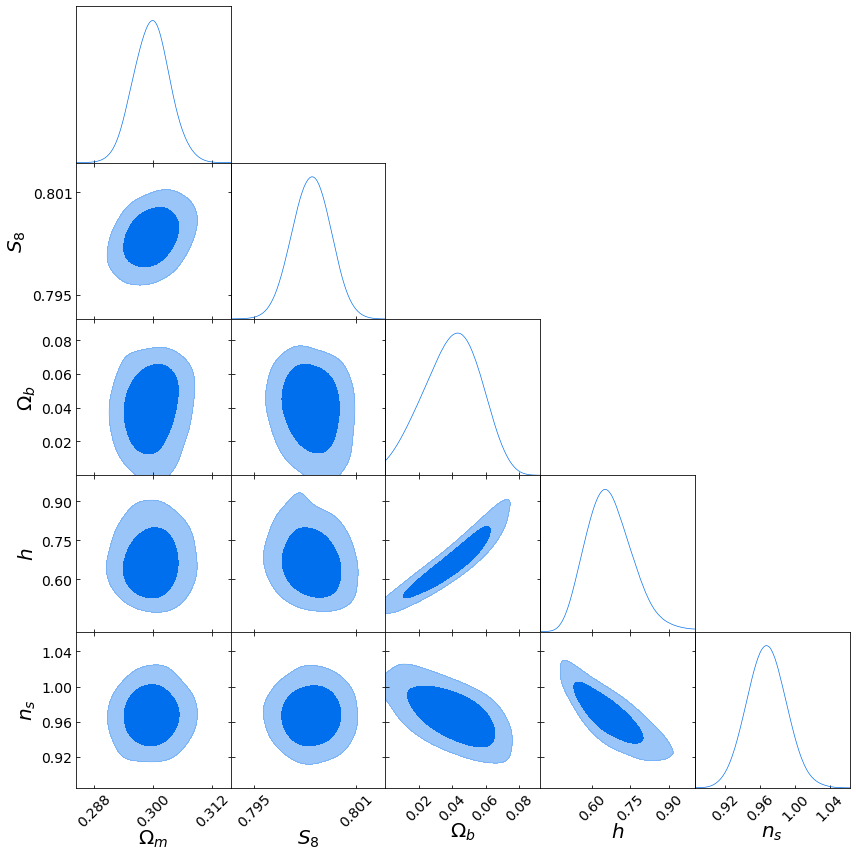

Population 23/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 10800 samples, validate on 1200 samples
Epoch 1/100
10800/10800 [==============================] - 27s 3ms/step - loss: 3.5357 - val_loss: 3.7097
Epoch 2/100
10800/10800 [==============================] - 30s 3ms/step - loss: 3.5518 - val_loss: 3.7328
Epoch 3/100
10800/10800 [==============================] - 28s 3ms/step - loss: 3.5123 - val_loss: 3.6897
Epoch 4/100
10800/10800 [==============================] - 26s 2ms/step - loss: 3.5126 - val_loss: 3.7513
Epoch 5/100
10800/10800 [==============================] - 27s 2ms/step - loss: 3.5173 - val_loss: 3.7918
Epoch 6/100
10800/10800 [==============================] - 26s 2ms/step - loss: 3.5594 - val_loss: 3.7245
Epoch 7/100
10800/10800 [==============================] - 26s 2ms/step - loss: 3.5333 - val_loss: 3.8339
Epoch 8/100
10800/10800 [==============================] - 27s 2ms/step - loss: 3.5349 - val_loss: 3.7028
Epoch 9/100
10800/10800 [

10800/10800 [==============================] - 65s 6ms/step - loss: 3.4162 - val_loss: 3.6620
Epoch 40/100
10800/10800 [==============================] - 64s 6ms/step - loss: 3.4165 - val_loss: 3.6617
Epoch 41/100
10800/10800 [==============================] - 64s 6ms/step - loss: 3.4159 - val_loss: 3.6608
Epoch 42/100
10800/10800 [==============================] - 63s 6ms/step - loss: 3.4157 - val_loss: 3.6596
Epoch 43/100
10800/10800 [==============================] - 63s 6ms/step - loss: 3.4159 - val_loss: 3.6573
Epoch 44/100
10800/10800 [==============================] - 63s 6ms/step - loss: 3.4150 - val_loss: 3.6558
Epoch 45/100
10800/10800 [==============================] - 65s 6ms/step - loss: 3.4148 - val_loss: 3.6540
Epoch 46/100
10800/10800 [==============================] - 63s 6ms/step - loss: 3.4145 - val_loss: 3.6522
Epoch 47/100
10800/10800 [==============================] - 63s 6ms/step - loss: 3.4141 - val_loss: 3.6515
Epoch 48/100
10800/10800 [========================

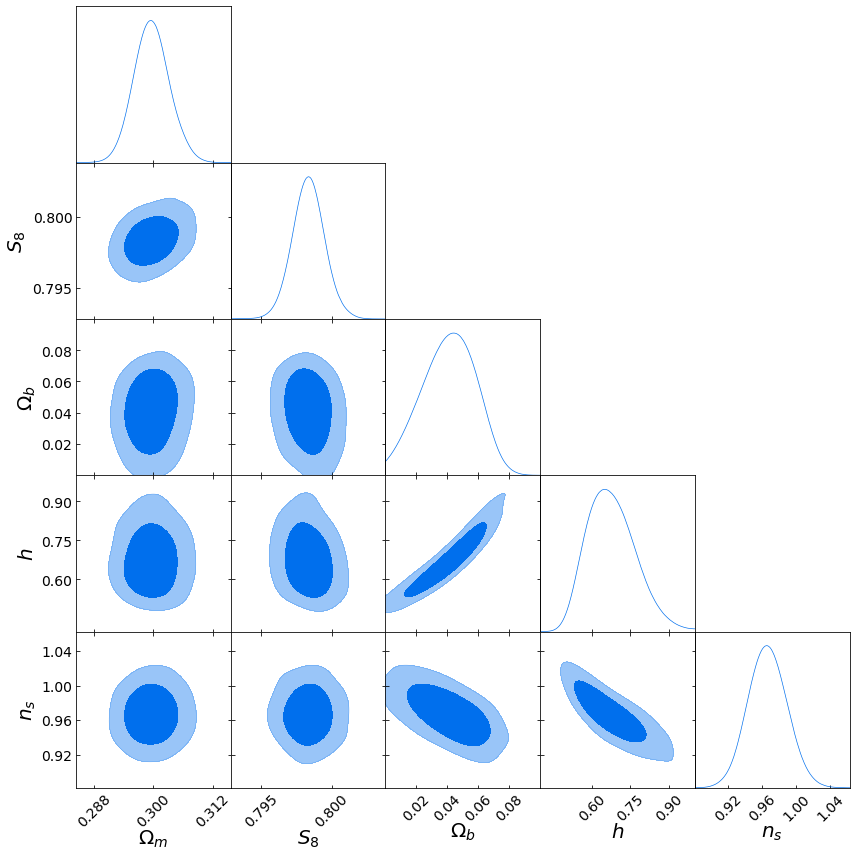

Final round of training with larger SGD batch size...
Train on 10800 samples, validate on 1200 samples
Epoch 1/300
10800/10800 [==============================] - 65s 6ms/step - loss: 3.4143 - val_loss: 3.6510
Epoch 2/300
10800/10800 [==============================] - 65s 6ms/step - loss: 3.4140 - val_loss: 3.6516
Epoch 3/300
10800/10800 [==============================] - 66s 6ms/step - loss: 3.4139 - val_loss: 3.6523
Epoch 4/300
10800/10800 [==============================] - 63s 6ms/step - loss: 3.4139 - val_loss: 3.6530
Epoch 5/300
10800/10800 [==============================] - 64s 6ms/step - loss: 3.4137 - val_loss: 3.6538
Epoch 6/300
10800/10800 [==============================] - 65s 6ms/step - loss: 3.4137 - val_loss: 3.6542
Epoch 7/300
10800/10800 [==============================] - 66s 6ms/step - loss: 3.4136 - val_loss: 3.6546
Epoch 8/300
10800/10800 [==============================] - 64s 6ms/step - loss: 3.4134 - val_loss: 3.6550
Epoch 9/300
10800/10800 [========================

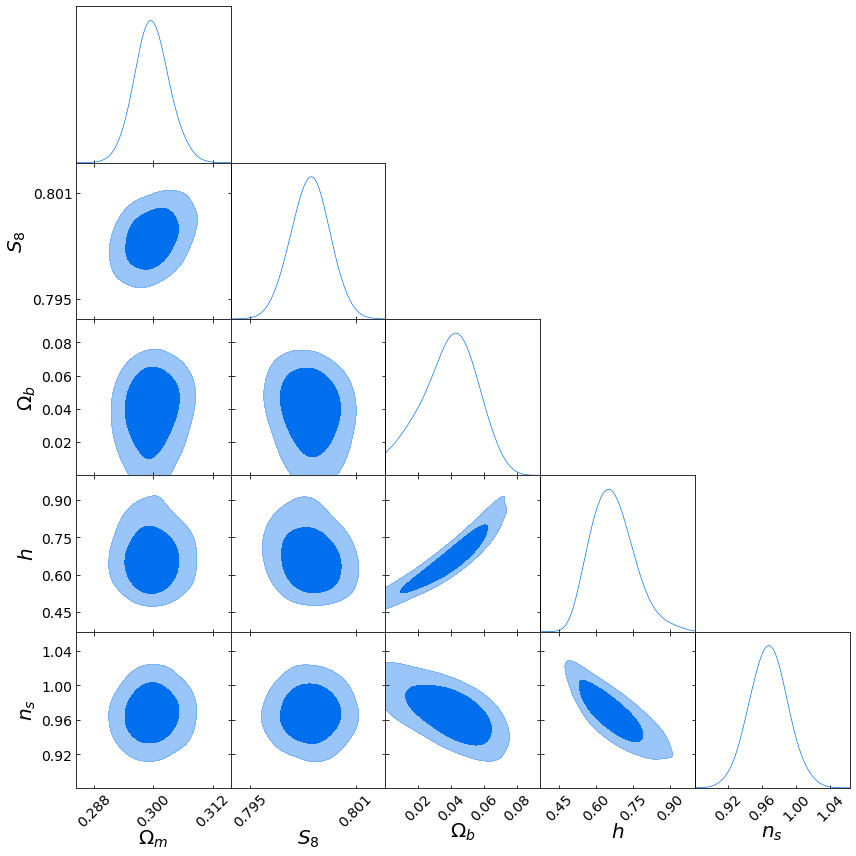

In [9]:
# Proposal for the SNL
proposal = priors.TruncatedGaussian(theta_fiducial, 9*Finv, lower, upper)

# Initial samples, batch size for population samples, number of populations
n_initial = 500
n_batch = 500
n_populations = 23

# Do the SNL training
mdn.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, proposal, simulator_args=simulator_args, compressor_args=compressor_args)

In [ ]:
plt.close()
columnwidth = 15 # cm
aspect = 1.67
pts_per_inch = 72.27
inch_per_cm = 2.54
width = columnwidth/inch_per_cm
plt.rcParams.update({'figure.figsize': [width, width / aspect],
                 'backend': 'pdf',
                 'font.size': 14,
                 'legend.fontsize': 'small',
                 'legend.frameon': False,
                 'legend.loc': 'best',
                 'lines.markersize': 3,
                 'lines.linewidth': .5,
                 'axes.linewidth': .5,
                 'axes.edgecolor': 'black',
                 'axes.color_cycle': ['#E41A1C', '#377EB8', '#4DAF4A', '#FF7F00']})

# Trace plot of the loss as a function of the number of simulations
plt.scatter(n_sims, loss_trace, s = 20)
plt.plot(n_sims, loss_trace, color = 'red', lw = 2)
plt.fill_between(mdn.n_sim_trace, loss_trace[-1]*0.99*np.ones(len(mdn.n_sim_trace)), loss_trace[-1]*1.01*np.ones(len(mdn.n_sim_trace)), color = 'grey', alpha = 0.2 )
plt.xlim(0, mdn.n_sim_trace[-1])
plt.axhline(loss_trace[-1], color = 'black', ls = '--')
plt.xlabel(r'number of simulations, $n_\mathrm{sims}$')
plt.ylabel(r'negative log-loss, $-\mathrm{ln}\,U$')
plt.show()